#GROUP 16,Code of skin lesion classifier model

# Loading Dataset

Downloading the dataset from {https://challenge.isic-archive.com/data/#2018}.

 The dataset consists of 10015 skin images from 7 classes. We will extract the images of 7 classes (Melanoma, Melanocytic nevi, Basal cell carcinoma, Actinic keratoses and intraepithelial carcinoma (akaic), Benign keratosis-like lesions, Dermatofibroma\ and Vascular lesions) and save them as .npy file


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score


In [ ]:
!pip install keras-tuner

In [ ]:
ground_truth_folder = "/content/drive/MyDrive/Colab Notebooks/Assignment/ground_truth_folder"
csv_file_path = os.path.join(ground_truth_folder, "ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
df = pd.read_csv(csv_file_path)

In [ ]:

file_dir = "/content/drive/MyDrive/Colab Notebooks/Assignment/"
data = np.load(file_dir + "data.npy")
labels = np.load(file_dir + "labels.npy", allow_pickle=True)
class_labels = np.load(file_dir + "labels_name.npy")


# Preprocessing

In [ ]:
#Create train, validation, and test sets using stratified train-test splits with ratios of 0.2(for both), and use a random seed of 42 for reproducibility
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
# Split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

In [ ]:

# Normalize your image data to floating point numbers between 0 and 1
X_train = train_images.astype('float32')/ 255.0
X_test = test_images.astype('float32')/ 255.0
X_val = val_images.astype('float32')/ 255.0

#Convert also the target labels to floats
y_train = train_labels.astype('float32')
y_test = test_labels.astype('float32')
y_val = val_labels.astype('float32')


In [ ]:
y_train.sum(axis = 0)

array([ 699., 4293.,  326.,  212.,  714.,   75.,   90.], dtype=float32)

# Visualizing Sample images
Randomly select 15 samples from the dataset. For each selected sample,display the image along with its corresponding label as text on top of the image.


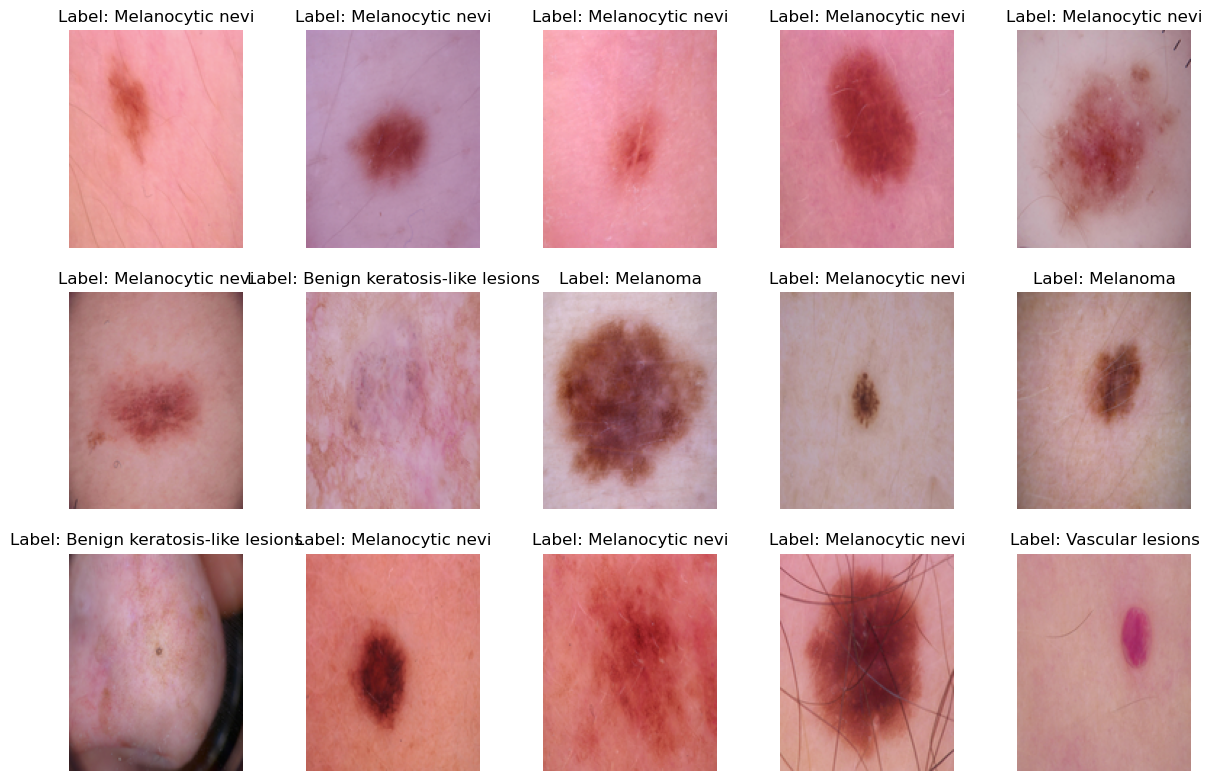

In [ ]:
import random

# Set the random seed for reproducibility
random.seed(42)

# Randomly select 15 samples
selected_indices = random.sample(range(len(data)), 15)

# Create a figure to display the images
fig, axs = plt.subplots(3, 5, figsize=(12, 8))
fig.tight_layout()

# Iterate over the selected indices
for i, idx in enumerate(selected_indices):
    # Get the image and corresponding label
    image = data[idx]
    label = class_labels[idx]

    # Reshape the label for display
    label_text = f"Label: {label}"

    # Get the corresponding subplot axes
    ax = axs[i // 5, i % 5]

    # Display the image and label
    ax.imshow(image)
    ax.set_title(label_text)
    ax.axis('off')

# Show the figure
plt.show()

# Visualize Class Label Distribution

In [ ]:
import matplotlib.pyplot as plt

# Count the number of samples for each class
class_counts = df.drop('image', axis=1).sum()

# Get the class labels and their corresponding counts
class_labels_name = class_counts.index
class_counts_value = class_counts.values
print(class_labels_name)
print(class_counts_value)



Index(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')
[1113. 6705.  514.  327. 1099.  115.  142.]


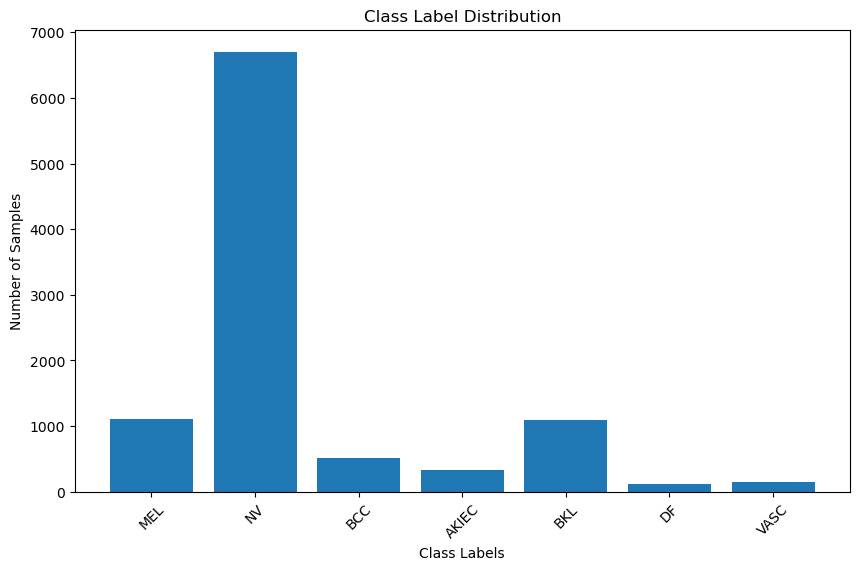

In [ ]:
# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_labels_name, class_counts_value)
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Label Distribution')
plt.xticks(rotation=45)
plt.show()

# Model building function

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

def build_model(input_data, optimizer='adam', lr= 0.001, # MUST: the input data here is to determine the shape of the input layer only
                loss='categorical_crossentropy',
                metrics='accuracy', activation= 'relu',
                # Use flipping for data augmentation?
                use_data_aug_flip= False, mode= 'horizontal_and_vertical',
                # Use rotation for data augmentation?
                use_data_aug_rot= False, factor= 0.2,
                # Use zooming for data augmentation?
                use_data_aug_zoom= False, zoom_range = ((-0.2, 0.2)),
                # Here if it is 2, it corresponds to two sets of Cov2D+Conv2D+MaxPooling. Minimum is 1.
                number_of_set_of_layers = 2,
                # Dropout and dropout rate
                use_dropout = False, dr= 0.1,
                # s_conv is the size of the Conv2D layer, s_maxpooling is the size of MaxPooling layer
                s_conv= 3, s_maxpooling= 2,
                # the number of each layer in each set of layers for Conv+Conv+MaxPooling.
                # Here the number of layers stays the same until Flatten.
                no_filter_1= 64, no_filter_2= 32,
                # Kernel regularizer
                regularizer_1 = None, #regularizers.l2(0.001)
                regularizer_2 = None, #regularizers.l2(0.001)
                # Number of Dense layers in fully connected, activation, and dropout rate
                number_of_dense= 2, activation_in_dense= 'relu', use_dropout_in_dense= False, dr_d= 0.4,
                output_activation= 'softmax'
              ):
    # Create a sequential model
    model = Sequential()
    from keras.optimizers import Adam
    if optimizer == 'adam':
      opt = Adam(lr = lr)

    # Data augmentation
    # Note: Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).
    if use_data_aug_zoom:
      model.add(layers.RandomZoom(height_factor= zoom_range, width_factor= zoom_range, seed= 42))
    if use_data_aug_flip:
      model.add(layers.RandomFlip(mode= mode))
    if use_data_aug_rot:
      model.add(layers.RandomRotation(factor= factor))

    # Add convolutional and pooling layers

    model.add(layers.Conv2D(no_filter_1, (s_conv, s_conv), padding="same", activation=activation, input_shape = input_data.shape[1:]))
    model.add(layers.Conv2D(no_filter_2, (s_conv, s_conv), padding="same", activation=activation, kernel_regularizer= regularizer_1))
    model.add(layers.MaxPooling2D((s_maxpooling, s_maxpooling)))
    for k in range(number_of_set_of_layers - 1):
        model.add(layers.Conv2D(no_filter_1, (s_conv, s_conv), padding="same", activation=activation, kernel_regularizer= regularizer_2))
        model.add(layers.Conv2D(no_filter_2, (s_conv, s_conv), padding="same", activation=activation))
        model.add(layers.MaxPooling2D((s_maxpooling, s_maxpooling)))
        if use_dropout:
            model.add(layers.Dropout(dr, seed= 42))




    # Add a Flatten layer to the model
    model.add(layers.Flatten())
    # Add two dense layers of sizes 32 with Relu activation function
    for k in range(number_of_dense):
        model.add(layers.Dense(32, activation=activation_in_dense))
    if use_dropout_in_dense:
        model.add(layers.Dropout(dr_d, seed= 42))
    # Add the last Dense layer.
    model.add(layers.Dense(7, activation=output_activation))
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metrics])
    return model


# Visualisation functions

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss', fontsize= 8)
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')

	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy', fontsize= 8)
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.show()


In [ ]:
#ROC curve with the AUC score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import RocCurveDisplay


def plot_ROC_curves(model, input_set_X, input_set_y, set_name, n_classes= 7):

    # Evaluate the model on validation sets
    pred_probs = model.predict(input_set_X)


    # multilabel ROC


    # plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


    # plotting the normal curves
    for i in range(n_classes):
        RocCurveDisplay.from_predictions(
            input_set_y[:, i],
            pred_probs[:, i],
            name=f"ROC curve for class {i}",
            ax=ax1
        )


    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # plotting micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(input_set_y.ravel(), pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )


    # calculating and plotting macro-average
    # calculation

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(input_set_y[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # plotting macro-average

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{0} Set: Receiver Operating Characteristic (ROC) Curve of model'.format(set_name))
    plt.legend()
    plt.show()
    return



In [ ]:
# Baseline model's confusion matrix for validation set

from sklearn.metrics import confusion_matrix

y_axis_labels= ['Melanoma (class 0)', 'Melanocytic nevi (class 1)',
              'Basal cell carcinoma (class 2)', 'Acaic (class 3)',
              'Benign keratosis-like lesions (class 4)',
              'Dermatofibromas (class 5)', 'Vascular lesions (class 6)']




def plot_confusion_matrix(model, input_set_X, input_set_y, set_name, threshold = 0.5, yticklabels= y_axis_labels):
    pred_probs = model.predict(input_set_X)
    pred_probs = (pred_probs > threshold)
    cm = confusion_matrix(input_set_y.argmax(axis=1), (pred_probs > 0.5).argmax(axis=1))
    import seaborn as sns
    sns.heatmap(cm, annot= True, fmt='g', yticklabels=yticklabels)
    plt.xlabel('Predicted label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of the {0} Set for the model'.format(set_name))
    plt.show()

    acc = accuracy_score(input_set_y.argmax(axis=1), (pred_probs > 0.5).argmax(axis=1))
    print('{} accuracy: %.3f'.format(set_name) % (acc))
    return


In [ ]:

from tabulate import tabulate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
model_f1_scores = {} # It is cleared everytime a runtime is restarted.
def acc_sens_spec_f1(model, input_set_X, input_set_y, set_name, threshold = 0.5):

    # Accuracy score
    acc = accuracy_score(input_set_y.argmax(axis=1), (model.predict(input_set_X) > threshold).argmax(axis=1))

    # sensitivity or recall and F-score
    _, sensitivity, f_score, _ = precision_recall_fscore_support(input_set_y.argmax(axis=1), (model.predict(input_set_X) > 0.5).argmax(axis=1), zero_division= 0)
    _, _, mean_macro_f_score, _ =  precision_recall_fscore_support(input_set_y.argmax(axis=1), (model.predict(input_set_X) > 0.5).argmax(axis=1), zero_division= 0, average= 'macro')
    _, _, weighted_macro_f_score, _ =  precision_recall_fscore_support(input_set_y.argmax(axis=1), (model.predict(input_set_X) > 0.5).argmax(axis=1), zero_division= 0, average= 'weighted')

    # Generate a confusion matrix for calculation
    cm = confusion_matrix(input_set_y.argmax(axis=1), (model.predict(input_set_X) > threshold).argmax(axis=1))
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    # Specificity
    specificity = TN / (TN + FP)
    # Sensitivity/Recall
    # sensitivity = TP/ (TP + FN)
    # f1_score
    # f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    metrics_data = []
    for i in range(len(f_score)):
        metrics_data.append([f'{i}',
                             f'{f_score[i]:.3f}',
                             f'{specificity[i]:.3f}',
                             f'{sensitivity[i]:.3f}'])


    # Create table and add headers
    headers = ['Class', 'F1 Score', 'Specificity', 'Sensitivity']
    table = tabulate(metrics_data, headers, tablefmt='pipe')

    print(f"{set_name} Accuracy: {acc:.3f}")
    print(f"{set_name} F1 Score (unweighted mean): {mean_macro_f_score:.3f}")
    print(f"{set_name} F1 Score (weighted mean): {weighted_macro_f_score:.3f}")
    print()
    print(table)
    return


In [ ]:
def fit_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, threshold = 0.5, number_of_epochs= 15, batch_size= 32, class_weight= None, callbacks= None):
    history = model.fit(X_train, y_train, epochs=number_of_epochs, batch_size=batch_size, validation_data=(X_val, y_val), class_weight = class_weight, callbacks= callbacks)
    # plot curves
    summarize_diagnostics(history)
    plot_ROC_curves(model= model, input_set_X= X_val, input_set_y= y_val, set_name= 'Validation')
    plot_ROC_curves(model= model, input_set_X= X_test, input_set_y= y_test, set_name= 'Test')
    plot_confusion_matrix(model= model, input_set_X = X_val, input_set_y= y_val, set_name= 'Validation')
    plot_confusion_matrix(model= model, input_set_X = X_test, input_set_y= y_test, set_name= 'Test')
    acc_sens_spec_f1(model= model, input_set_X = X_val, input_set_y = y_val, set_name= 'Validation', threshold = threshold)
    acc_sens_spec_f1(model= model, input_set_X = X_test, input_set_y = y_test, set_name= 'Test', threshold = threshold)
    model.summary()
    return

# Baseline Model

In [ ]:
# Build a baseline model and fit it to the training and validation data
number_of_epochs = 10
batch_size = 32
baseline_model = build_model(X_train) # It is to determine the shape of the input layer be the same as X train's

In [ ]:
baseline_history = baseline_model.fit(X_train, y_train, epochs=number_of_epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
201/201 [==============================] - 17s 22ms/step - loss: 1.0418 - accuracy: 0.6672 - val_loss: 1.0041 - val_accuracy: 0.6856
Epoch 2/10
201/201 [==============================] - 3s 16ms/step - loss: 0.9560 - accuracy: 0.6741 - val_loss: 0.9530 - val_accuracy: 0.6731
Epoch 3/10
201/201 [==============================] - 3s 16ms/step - loss: 0.8995 - accuracy: 0.6795 - val_loss: 0.9159 - val_accuracy: 0.6862
Epoch 4/10
201/201 [==============================] - 3s 16ms/step - loss: 0.8823 - accuracy: 0.6814 - val_loss: 0.9340 - val_accuracy: 0.6881
Epoch 5/10
201/201 [==============================] - 3s 17ms/step - loss: 0.8462 - accuracy: 0.6948 - val_loss: 0.8571 - val_accuracy: 0.6962
Epoch 6/10
201/201 [==============================] - 3s 17ms/step - loss: 0.7995 - accuracy: 0.7034 - val_loss: 0.8176 - val_accuracy: 0.6987
Epoch 7/10
201/201 [==============================] - 3s 16ms/step - loss: 0.7787 - accuracy: 0.7110 - val_loss: 0.8069 - val_accuracy: 0.705

In [ ]:
# Check the baseline CNN algorithm
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 120, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 120, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 60, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 30, 32)        0         
 g2D)                                                   

#### Baseline model history

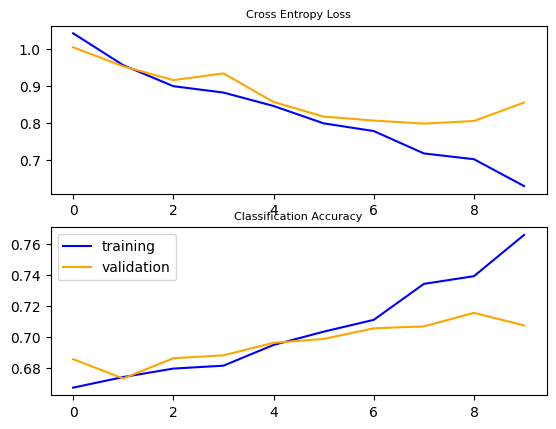

In [ ]:
summarize_diagnostics(baseline_history)

#### Plot ROC Curves for validation and test sets, respectively

51/51 [==============================] - 0s 5ms/step


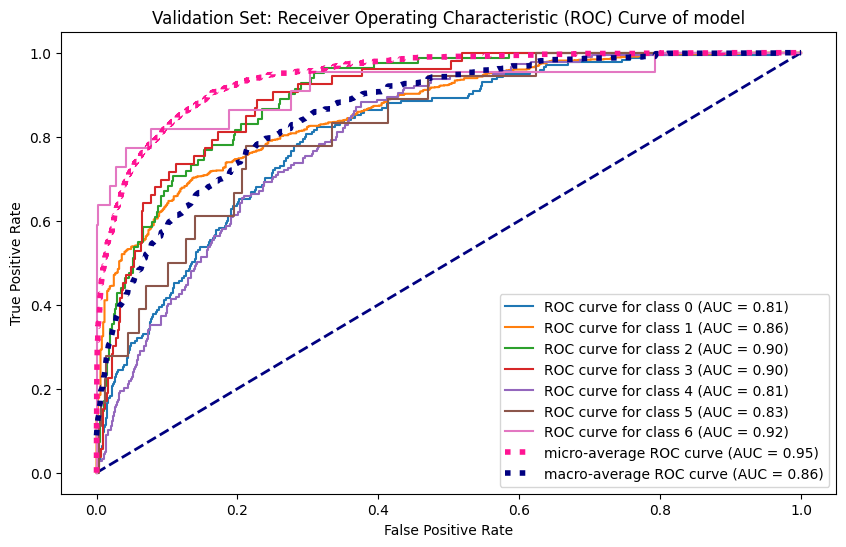

63/63 [==============================] - 0s 7ms/step


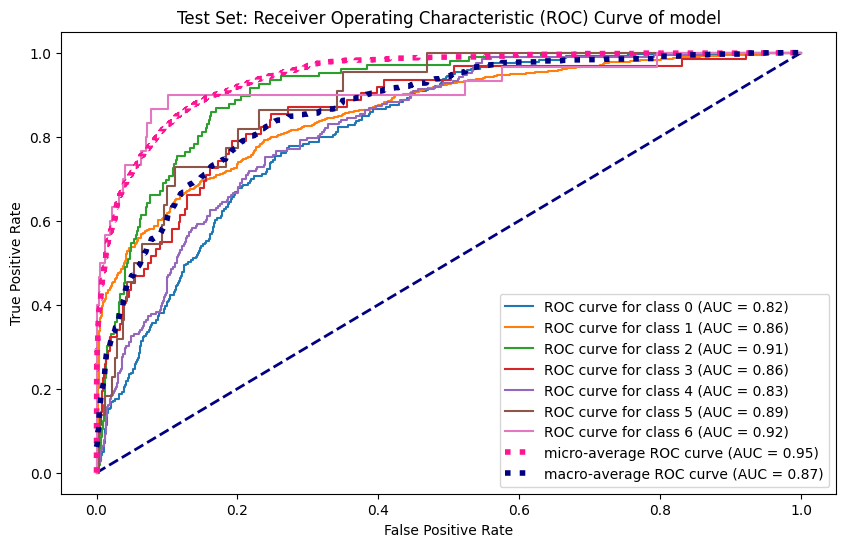

In [ ]:
plot_ROC_curves(model= baseline_model, input_set_X= X_val, input_set_y= y_val, set_name= 'Validation')
plot_ROC_curves(model= baseline_model, input_set_X= X_test, input_set_y= y_test, set_name= 'Test')

##Plot confusion matrix for validation and test sets,respectively

51/51 [==============================] - 0s 5ms/step


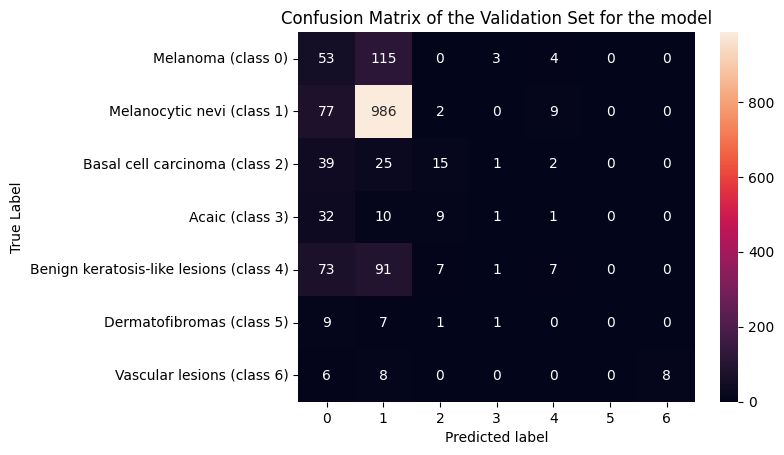

Validation accuracy: 0.667
63/63 [==============================] - 0s 5ms/step


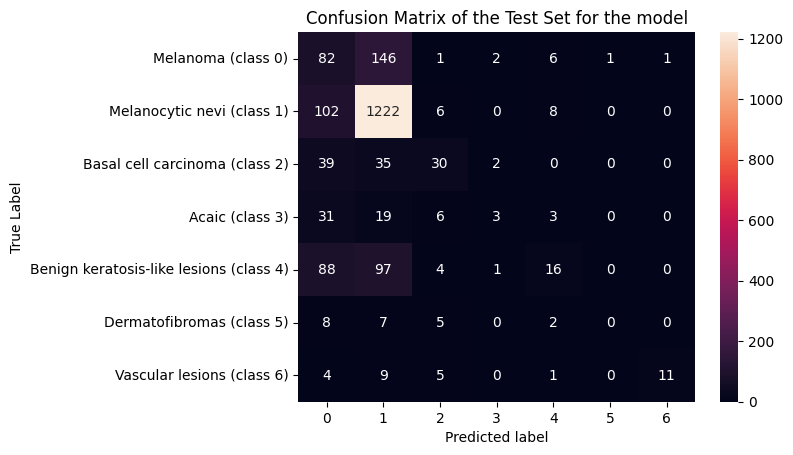

Test accuracy: 0.681


In [ ]:
plot_confusion_matrix(model= baseline_model, input_set_X = X_val, input_set_y= y_val, set_name= 'Validation')
plot_confusion_matrix(model= baseline_model, input_set_X = X_test, input_set_y= y_test, set_name= 'Test')

## Report performance measures: accuracy, sensitivity, specificity, and F1-score

In [ ]:
# Generate the tables for our validation and test sets

acc_sens_spec_f1(model= baseline_model, input_set_X = X_val, input_set_y = y_val, set_name= 'Validation')
acc_sens_spec_f1(model= baseline_model, input_set_X = X_test, input_set_y = y_test, set_name= 'Test')

51/51 [==============================] - 0s 5ms/step
Validation Accuracy: 0.667
Validation F1 Score (unweighted mean): 0.282
Validation F1 Score (weighted mean): 0.625

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.228 |         0.835 |         0.303 |
|       1 |      0.851 |         0.516 |         0.918 |
|       2 |      0.259 |         0.988 |         0.183 |
|       3 |      0.033 |         0.996 |         0.019 |
|       4 |      0.069 |         0.989 |         0.039 |
|       5 |      0     |         1     |         0     |
|       6 |      0.533 |         1     |         0.364 |
63/63 [==============================] - 0s 5ms/step
Test Accuracy: 0.681
Test F1 Score (unweighted mean): 0.320
Test F1 Score (weighted mean): 0.645

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.277 |         0.846 |         0.34

# Hyperparameters (epoch) Tuning

## 20 epoch times

In [ ]:
adam_model = build_model(input_data= X_train, optimizer= 'adam')

Epoch 1/20
201/201 [==============================] - 16s 22ms/step - loss: 1.0484 - accuracy: 0.6672 - val_loss: 0.9914 - val_accuracy: 0.6700
Epoch 2/20
201/201 [==============================] - 3s 16ms/step - loss: 0.9144 - accuracy: 0.6714 - val_loss: 0.9244 - val_accuracy: 0.6719
Epoch 3/20
201/201 [==============================] - 3s 17ms/step - loss: 0.8760 - accuracy: 0.6811 - val_loss: 0.9489 - val_accuracy: 0.6831
Epoch 4/20
201/201 [==============================] - 3s 16ms/step - loss: 0.8350 - accuracy: 0.6917 - val_loss: 0.8727 - val_accuracy: 0.6843
Epoch 5/20
201/201 [==============================] - 3s 16ms/step - loss: 0.7937 - accuracy: 0.7079 - val_loss: 0.8351 - val_accuracy: 0.6962
Epoch 6/20
201/201 [==============================] - 3s 16ms/step - loss: 0.7361 - accuracy: 0.7335 - val_loss: 0.8249 - val_accuracy: 0.6987
Epoch 7/20
201/201 [==============================] - 3s 16ms/step - loss: 0.6862 - accuracy: 0.7482 - val_loss: 0.8792 - val_accuracy: 0.702

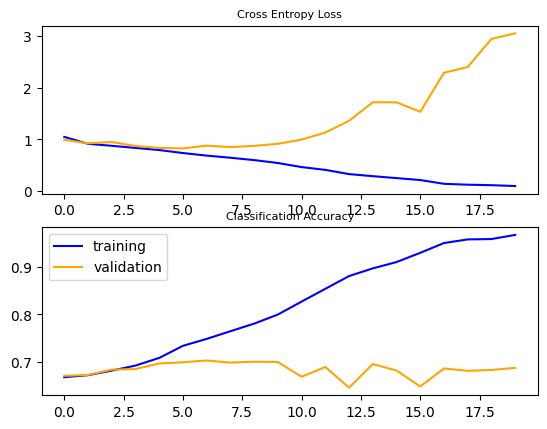

51/51 [==============================] - 0s 5ms/step


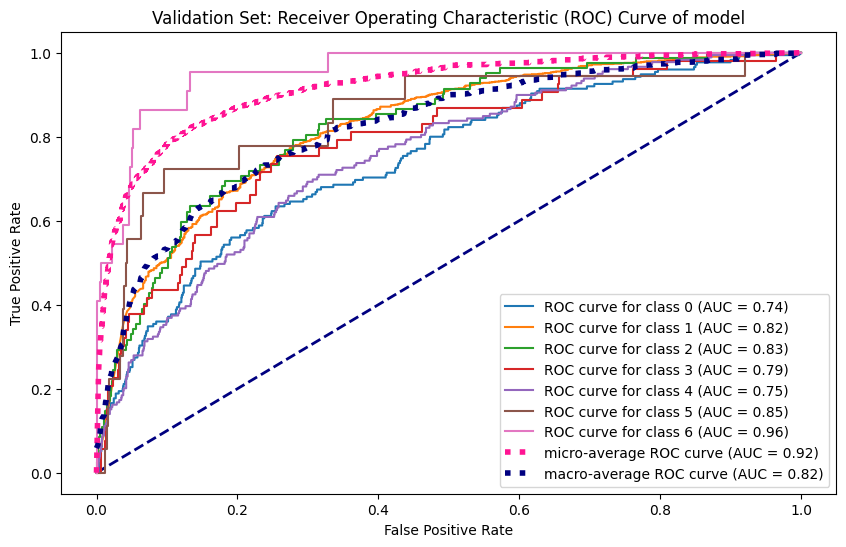

63/63 [==============================] - 0s 7ms/step


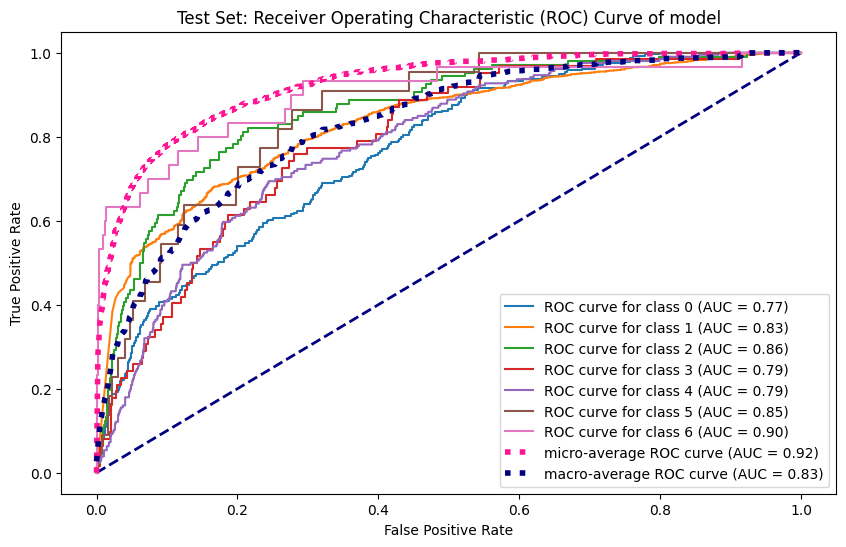

51/51 [==============================] - 0s 5ms/step


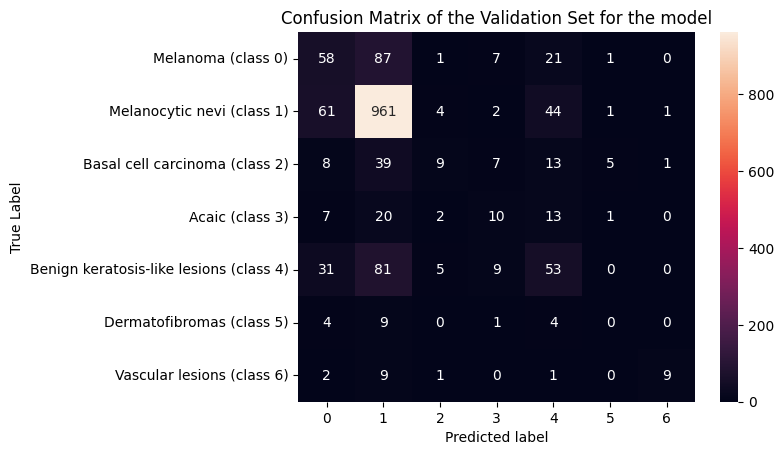

Validation accuracy: 0.686
63/63 [==============================] - 0s 5ms/step


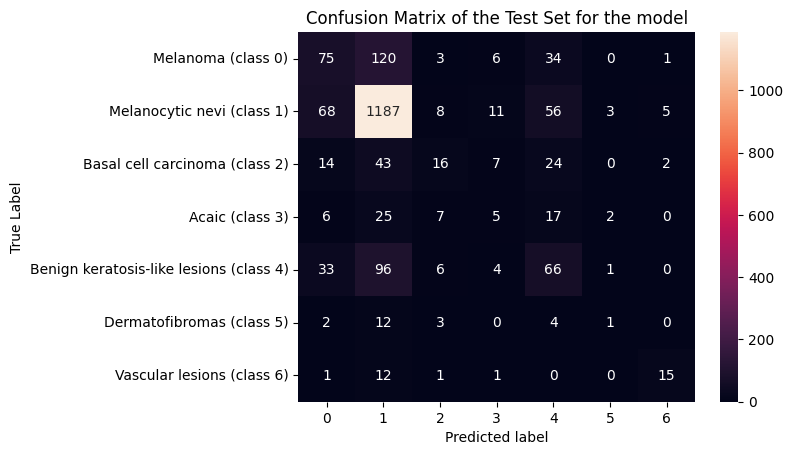

Test accuracy: 0.681
51/51 [==============================] - 0s 5ms/step
Validation Accuracy: 0.686
Validation F1 Score (unweighted mean): 0.349
Validation F1 Score (weighted mean): 0.661

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.335 |         0.921 |         0.331 |
|       1 |      0.843 |         0.537 |         0.895 |
|       2 |      0.173 |         0.991 |         0.11  |
|       3 |      0.225 |         0.983 |         0.189 |
|       4 |      0.323 |         0.933 |         0.296 |
|       5 |      0     |         0.995 |         0     |
|       6 |      0.545 |         0.999 |         0.409 |
63/63 [==============================] - 0s 5ms/step
Test Accuracy: 0.681
Test F1 Score (unweighted mean): 0.351
Test F1 Score (weighted mean): 0.658

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.342 |        

In [ ]:
# fit & summarize & display metrics
fit_plot(adam_model, X_train= X_train, y_train= y_train, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 20)

# Hyperparameters (Optimizer) Tuning
This section changes the optimizer based on epoch times being 20. Then the layer number is changed from 2 to 3.

## Rmsprop

In [ ]:
rmsprop_model = build_model(input_data= X_train, optimizer= 'rmsprop')

Epoch 1/20
201/201 [==============================] - 6s 21ms/step - loss: 1.1246 - accuracy: 0.6580 - val_loss: 1.1715 - val_accuracy: 0.6700
Epoch 2/20
201/201 [==============================] - 3s 17ms/step - loss: 0.9626 - accuracy: 0.6698 - val_loss: 0.9318 - val_accuracy: 0.6725
Epoch 3/20
201/201 [==============================] - 3s 17ms/step - loss: 0.9137 - accuracy: 0.6773 - val_loss: 1.0265 - val_accuracy: 0.6719
Epoch 4/20
201/201 [==============================] - 3s 17ms/step - loss: 0.8948 - accuracy: 0.6922 - val_loss: 0.8329 - val_accuracy: 0.6875
Epoch 5/20
201/201 [==============================] - 3s 17ms/step - loss: 0.8259 - accuracy: 0.6967 - val_loss: 0.8076 - val_accuracy: 0.7093
Epoch 6/20
201/201 [==============================] - 3s 17ms/step - loss: 0.7868 - accuracy: 0.7081 - val_loss: 0.9338 - val_accuracy: 0.6968
Epoch 7/20
201/201 [==============================] - 3s 17ms/step - loss: 0.7503 - accuracy: 0.7249 - val_loss: 0.9248 - val_accuracy: 0.6999

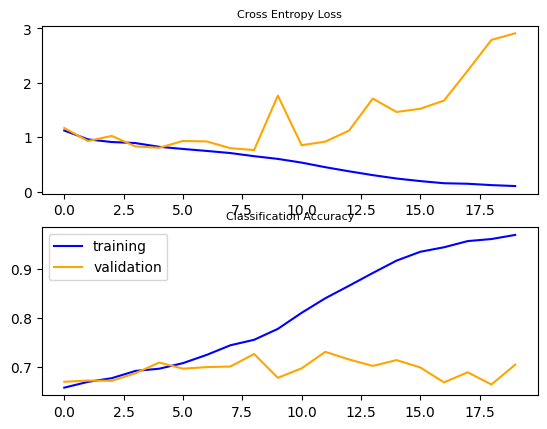

51/51 [==============================] - 0s 5ms/step


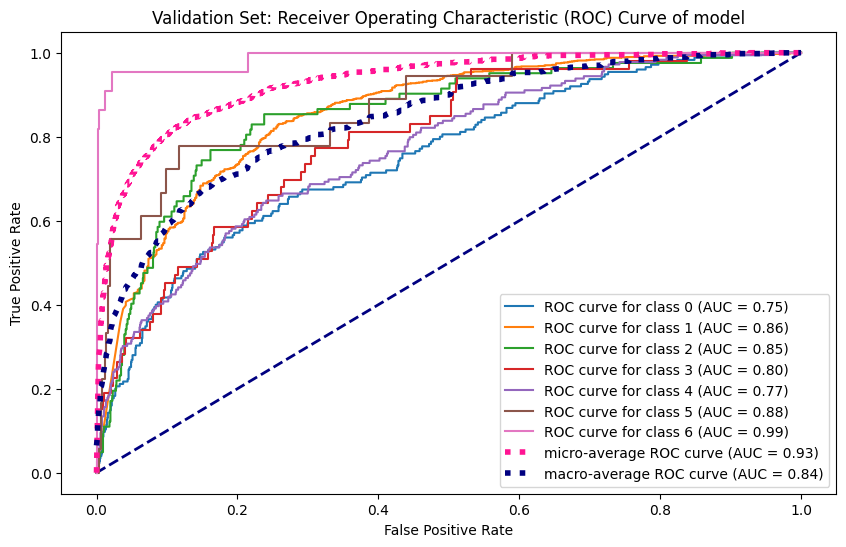

63/63 [==============================] - 0s 5ms/step


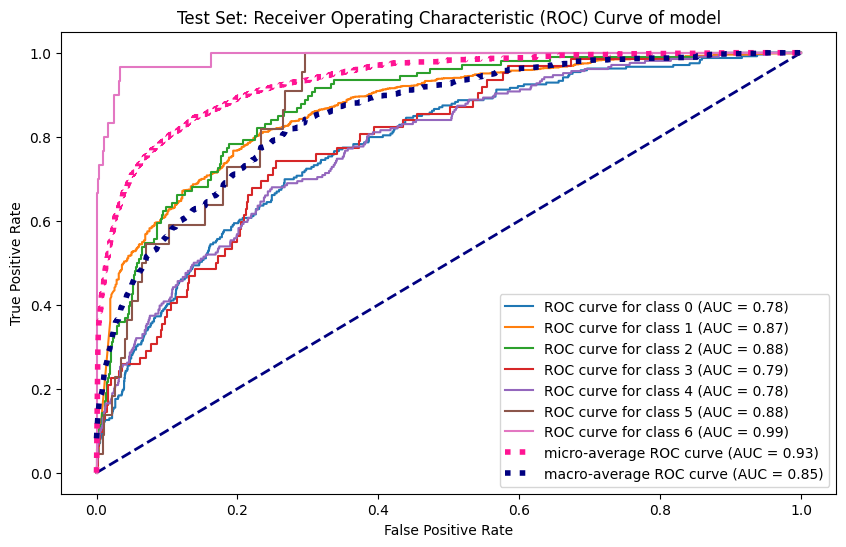

51/51 [==============================] - 0s 5ms/step


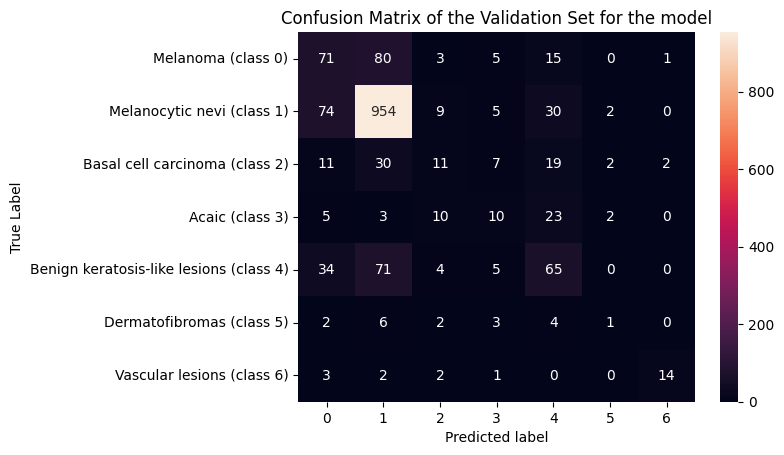

Validation accuracy: 0.702
63/63 [==============================] - 0s 5ms/step


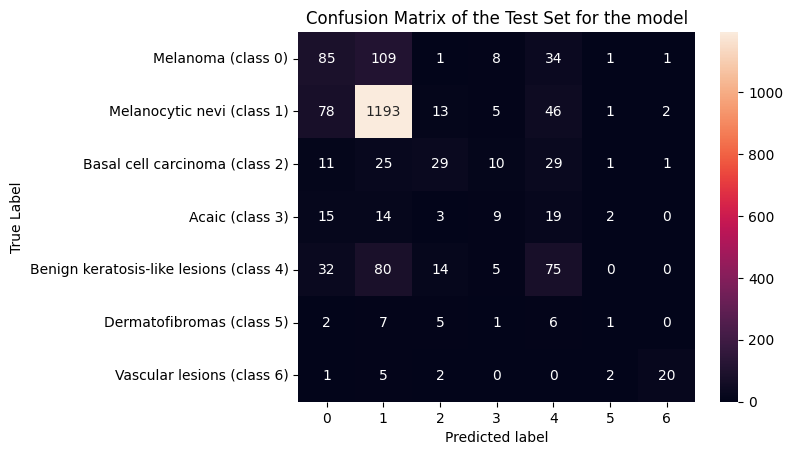

Test accuracy: 0.705
51/51 [==============================] - 0s 7ms/step
Validation Accuracy: 0.702
Validation F1 Score (unweighted mean): 0.404
Validation F1 Score (weighted mean): 0.688

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.379 |         0.91  |         0.406 |
|       1 |      0.859 |         0.637 |         0.888 |
|       2 |      0.179 |         0.98  |         0.134 |
|       3 |      0.225 |         0.983 |         0.189 |
|       4 |      0.388 |         0.936 |         0.363 |
|       5 |      0.08  |         0.996 |         0.056 |
|       6 |      0.718 |         0.998 |         0.636 |
63/63 [==============================] - 0s 5ms/step
Test Accuracy: 0.705
Test F1 Score (unweighted mean): 0.416
Test F1 Score (weighted mean): 0.691

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.367 |        

In [ ]:
# fit & summarize & display metrics
fit_plot(rmsprop_model, X_train= X_train, y_train= y_train, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 20)

##Adamax

In [ ]:
adamax_model = build_model(input_data= X_train, optimizer= 'adamax')

Epoch 1/20
201/201 [==============================] - 7s 20ms/step - loss: 1.0750 - accuracy: 0.6664 - val_loss: 0.9789 - val_accuracy: 0.6700
Epoch 2/20
201/201 [==============================] - 3s 17ms/step - loss: 0.9560 - accuracy: 0.6758 - val_loss: 0.9495 - val_accuracy: 0.6906
Epoch 3/20
201/201 [==============================] - 3s 17ms/step - loss: 0.9119 - accuracy: 0.6800 - val_loss: 0.9264 - val_accuracy: 0.6781
Epoch 4/20
201/201 [==============================] - 3s 17ms/step - loss: 0.8789 - accuracy: 0.6925 - val_loss: 0.8864 - val_accuracy: 0.6968
Epoch 5/20
201/201 [==============================] - 3s 16ms/step - loss: 0.8504 - accuracy: 0.6951 - val_loss: 0.8632 - val_accuracy: 0.6956
Epoch 6/20
201/201 [==============================] - 3s 16ms/step - loss: 0.8342 - accuracy: 0.7015 - val_loss: 0.8927 - val_accuracy: 0.6993
Epoch 7/20
201/201 [==============================] - 3s 16ms/step - loss: 0.8061 - accuracy: 0.7095 - val_loss: 0.8359 - val_accuracy: 0.6981

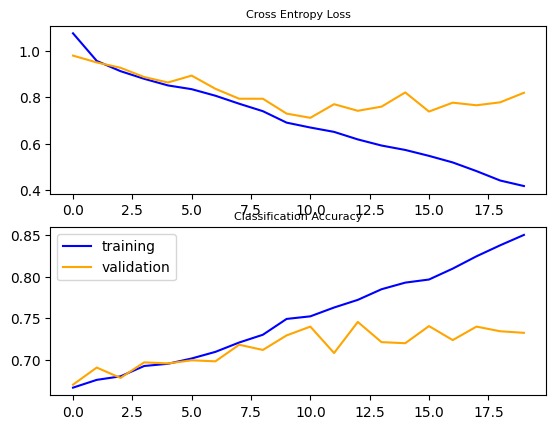

51/51 [==============================] - 0s 5ms/step


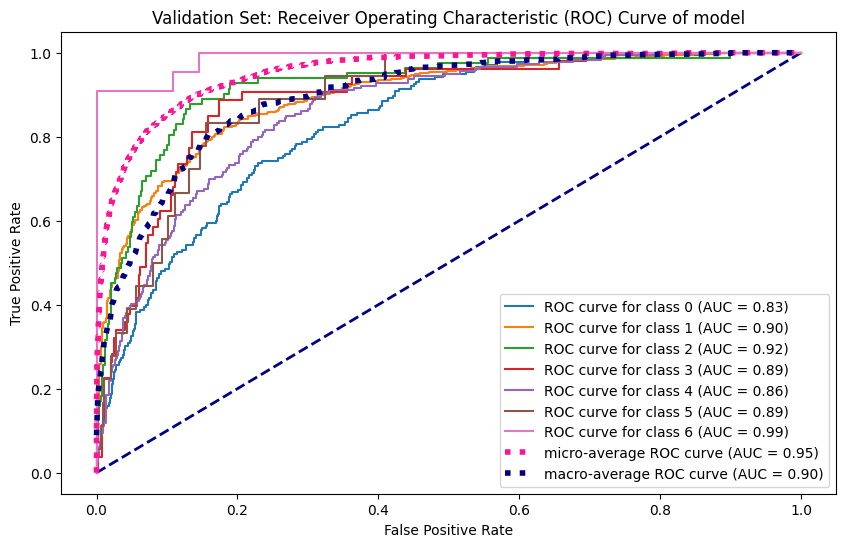

63/63 [==============================] - 0s 5ms/step


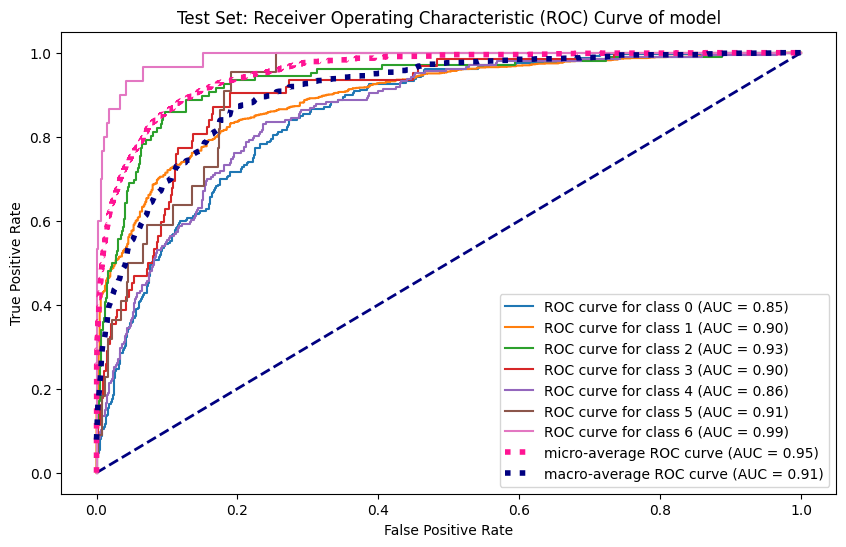

51/51 [==============================] - 0s 5ms/step


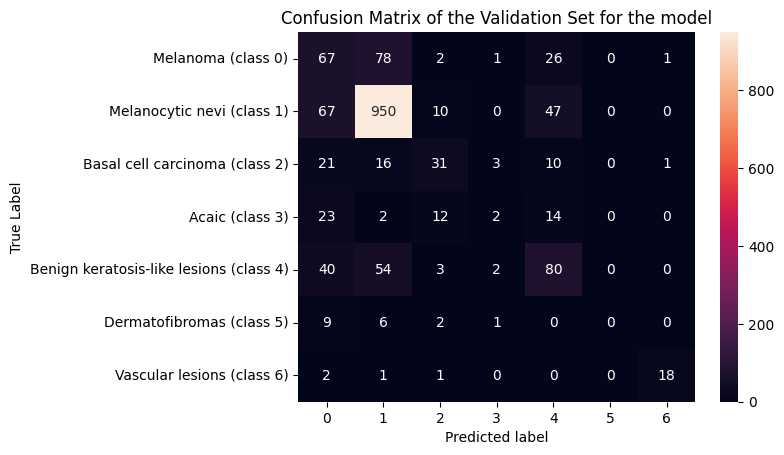

Validation accuracy: 0.716
63/63 [==============================] - 0s 5ms/step


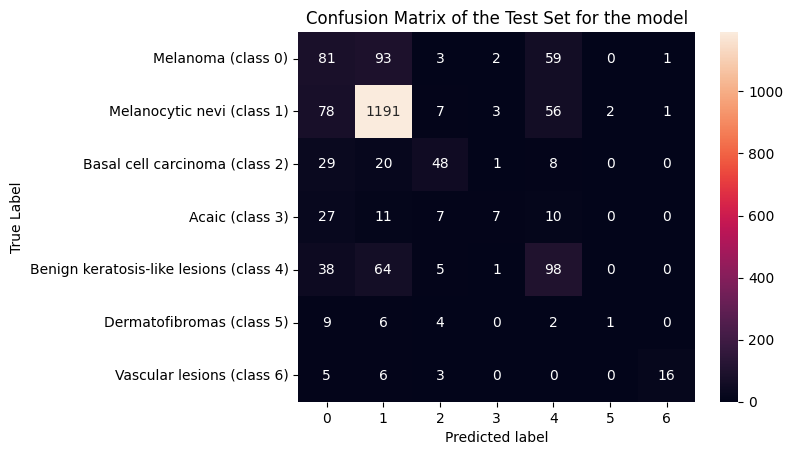

Test accuracy: 0.720
51/51 [==============================] - 0s 5ms/step
Validation Accuracy: 0.716
Validation F1 Score (unweighted mean): 0.430
Validation F1 Score (weighted mean): 0.706

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.332 |         0.887 |         0.383 |
|       1 |      0.871 |         0.703 |         0.885 |
|       2 |      0.434 |         0.98  |         0.378 |
|       3 |      0.065 |         0.995 |         0.038 |
|       4 |      0.449 |         0.932 |         0.447 |
|       5 |      0     |         1     |         0     |
|       6 |      0.857 |         0.999 |         0.818 |
63/63 [==============================] - 0s 5ms/step
Test Accuracy: 0.720
Test F1 Score (unweighted mean): 0.442
Test F1 Score (weighted mean): 0.712

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.32  |        

In [ ]:
# fit & summarize & display metrics
fit_plot(adamax_model, X_train= X_train, y_train= y_train, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 20)

## Nadam

In [ ]:
nadam_model = build_model(input_data= X_train, optimizer= 'nadam')

Epoch 1/20
201/201 [==============================] - 8s 23ms/step - loss: 1.0274 - accuracy: 0.6661 - val_loss: 0.9699 - val_accuracy: 0.6694
Epoch 2/20
201/201 [==============================] - 4s 19ms/step - loss: 0.9040 - accuracy: 0.6722 - val_loss: 0.8958 - val_accuracy: 0.6862
Epoch 3/20
201/201 [==============================] - 4s 19ms/step - loss: 0.8741 - accuracy: 0.6801 - val_loss: 0.8814 - val_accuracy: 0.6750
Epoch 4/20
201/201 [==============================] - 4s 19ms/step - loss: 0.8302 - accuracy: 0.6975 - val_loss: 0.8798 - val_accuracy: 0.6756
Epoch 5/20
201/201 [==============================] - 4s 19ms/step - loss: 0.7930 - accuracy: 0.7067 - val_loss: 0.9064 - val_accuracy: 0.6525
Epoch 6/20
201/201 [==============================] - 4s 19ms/step - loss: 0.7579 - accuracy: 0.7168 - val_loss: 0.7791 - val_accuracy: 0.7099
Epoch 7/20
201/201 [==============================] - 4s 19ms/step - loss: 0.7129 - accuracy: 0.7343 - val_loss: 0.7940 - val_accuracy: 0.7249

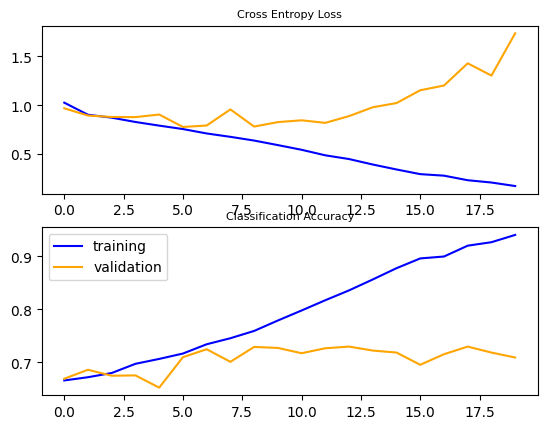

51/51 [==============================] - 0s 5ms/step


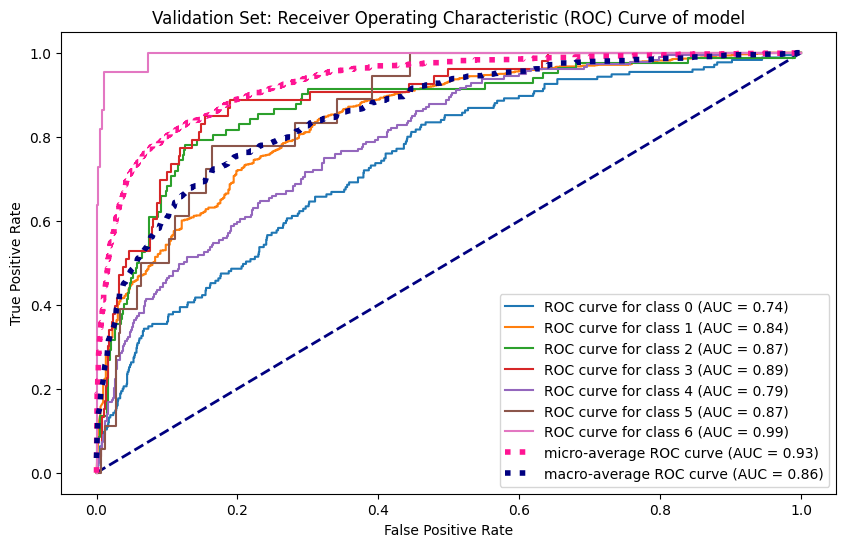

63/63 [==============================] - 0s 5ms/step


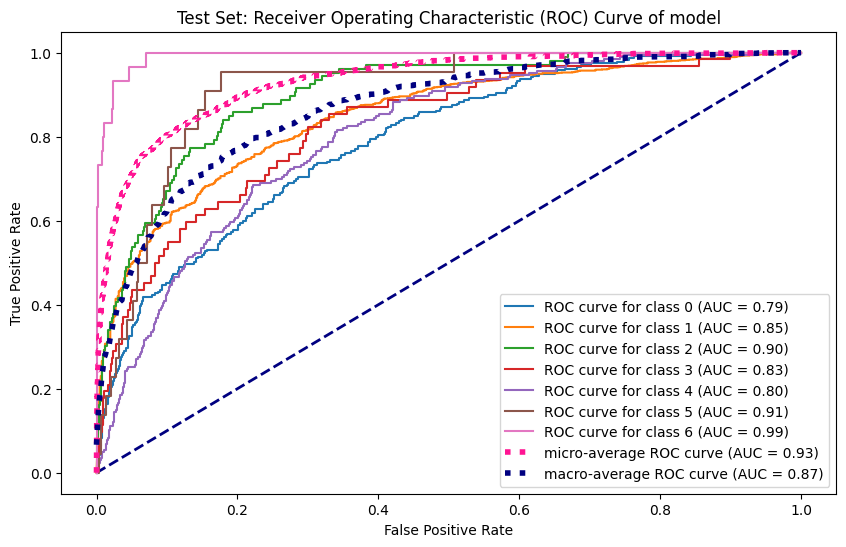

51/51 [==============================] - 0s 5ms/step


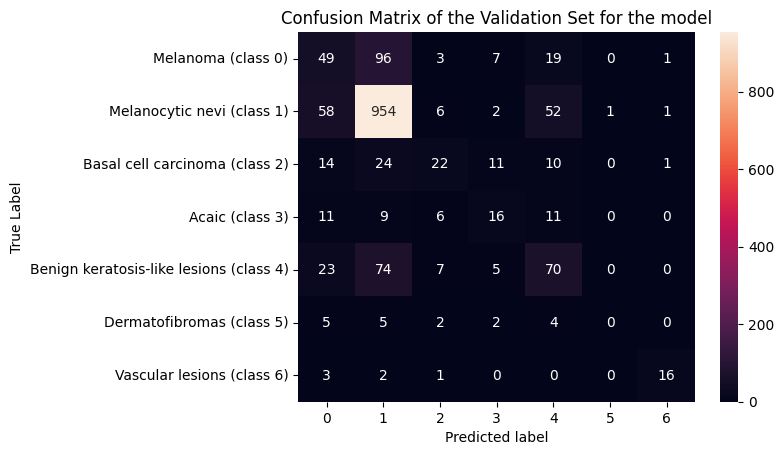

Validation accuracy: 0.703
63/63 [==============================] - 0s 5ms/step


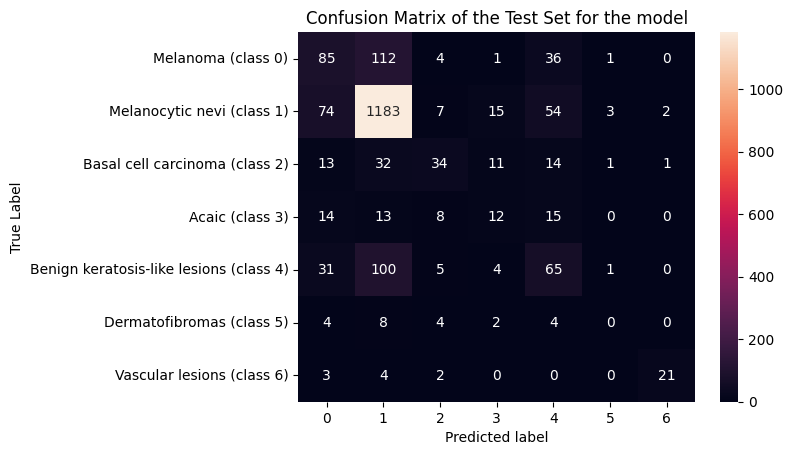

Test accuracy: 0.699
51/51 [==============================] - 0s 5ms/step
Validation Accuracy: 0.703
Validation F1 Score (unweighted mean): 0.429
Validation F1 Score (weighted mean): 0.687

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.29  |         0.92  |         0.28  |
|       1 |      0.853 |         0.603 |         0.888 |
|       2 |      0.341 |         0.984 |         0.268 |
|       3 |      0.333 |         0.983 |         0.302 |
|       4 |      0.406 |         0.933 |         0.391 |
|       5 |      0     |         0.999 |         0     |
|       6 |      0.78  |         0.998 |         0.727 |
63/63 [==============================] - 0s 5ms/step
Test Accuracy: 0.699
Test F1 Score (unweighted mean): 0.421
Test F1 Score (weighted mean): 0.684

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.367 |        

In [ ]:
# fit & summarize & display metrics
fit_plot(nadam_model, X_train= X_train, y_train= y_train, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 20)

#Hyperparameters (Loss) Tuning


##Categorical focal cross entropy

Epoch 1/20
201/201 [==============================] - 6s 20ms/step - loss: 0.1808 - accuracy: 0.6096 - val_loss: 0.1533 - val_accuracy: 0.6700
Epoch 2/20
201/201 [==============================] - 3s 16ms/step - loss: 0.1461 - accuracy: 0.6694 - val_loss: 0.1438 - val_accuracy: 0.6700
Epoch 3/20
201/201 [==============================] - 3s 16ms/step - loss: 0.1416 - accuracy: 0.6697 - val_loss: 0.1456 - val_accuracy: 0.6706
Epoch 4/20
201/201 [==============================] - 3s 16ms/step - loss: 0.1362 - accuracy: 0.6706 - val_loss: 0.1472 - val_accuracy: 0.6700
Epoch 5/20
201/201 [==============================] - 3s 16ms/step - loss: 0.1307 - accuracy: 0.6697 - val_loss: 0.1429 - val_accuracy: 0.6818
Epoch 6/20
201/201 [==============================] - 3s 16ms/step - loss: 0.1271 - accuracy: 0.6739 - val_loss: 0.1308 - val_accuracy: 0.6775
Epoch 7/20
201/201 [==============================] - 3s 16ms/step - loss: 0.1229 - accuracy: 0.6778 - val_loss: 0.1324 - val_accuracy: 0.6862

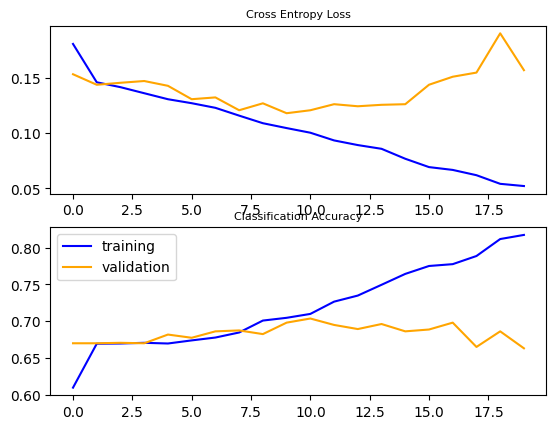

51/51 [==============================] - 0s 5ms/step


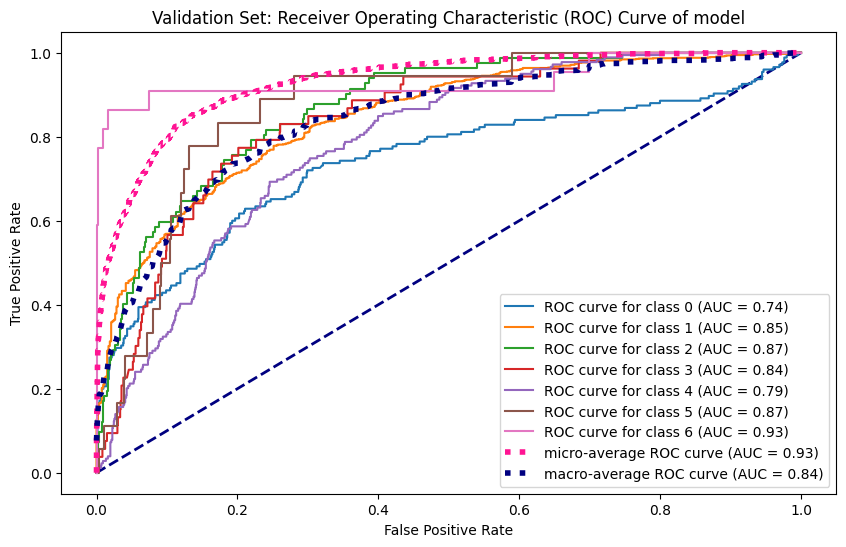

63/63 [==============================] - 0s 5ms/step


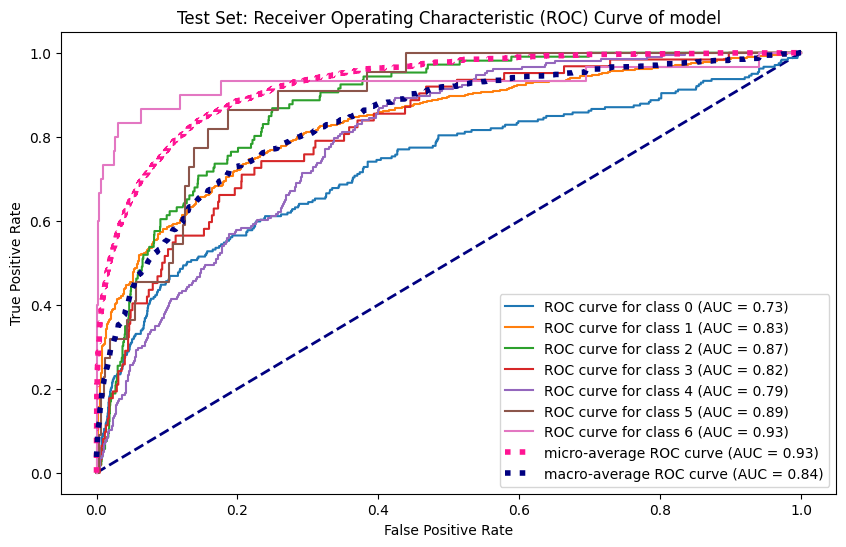

51/51 [==============================] - 0s 5ms/step


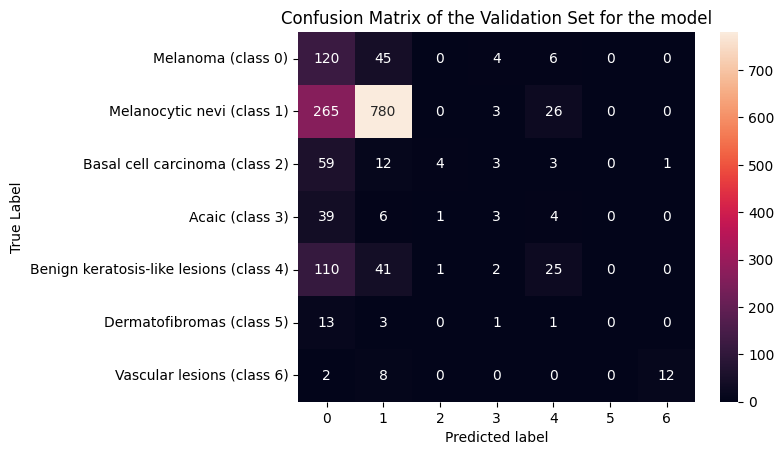

Validation accuracy: 0.589
63/63 [==============================] - 0s 5ms/step


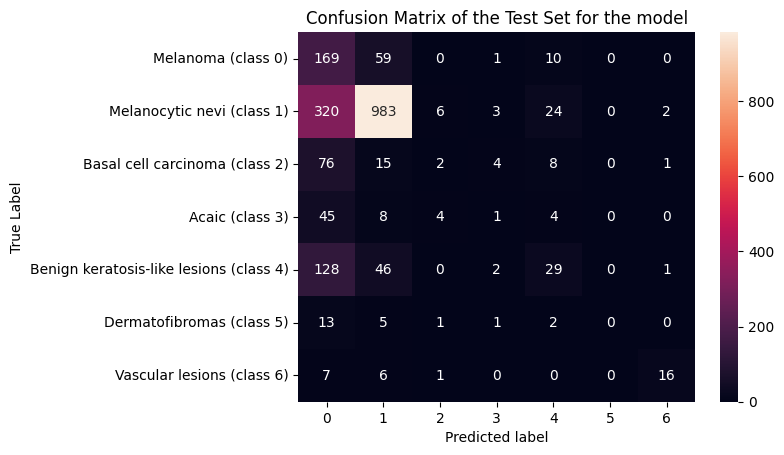

Test accuracy: 0.599
51/51 [==============================] - 0s 5ms/step
Validation Accuracy: 0.589
Validation F1 Score (unweighted mean): 0.310
Validation F1 Score (weighted mean): 0.604

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.307 |         0.658 |         0.686 |
|       1 |      0.792 |         0.783 |         0.726 |
|       2 |      0.091 |         0.999 |         0.049 |
|       3 |      0.087 |         0.992 |         0.057 |
|       4 |      0.205 |         0.972 |         0.14  |
|       5 |      0     |         1     |         0     |
|       6 |      0.686 |         0.999 |         0.545 |
63/63 [==============================] - 0s 5ms/step
Test Accuracy: 0.599
Test F1 Score (unweighted mean): 0.292
Test F1 Score (weighted mean): 0.608

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.339 |        

In [ ]:
from keras.src.backend import categorical_focal_crossentropy
categoricalfocalcrossentropy_model = build_model(X_train, loss= 'categorical_focal_crossentropy')
fit_plot(categoricalfocalcrossentropy_model, X_train, y_train, X_val, y_val, X_test, y_test, number_of_epochs= 20, batch_size= 32)

# Hyperparameters (Convolutional layer number) Tuning

##Convolutional layer number = 3
Then the layer number is changed from 2 to 3.

 Optimizer is Adam. Not much difference compared to baseline. Unsure whether the slight increase in test accuracy is significant.

In [ ]:
trilayered_adam_model = build_model(X_train, number_of_set_of_layers= 3)

Epoch 1/20
201/201 [==============================] - 17s 24ms/step - loss: 1.0904 - accuracy: 0.6519 - val_loss: 1.0173 - val_accuracy: 0.6700
Epoch 2/20
201/201 [==============================] - 3s 17ms/step - loss: 0.9756 - accuracy: 0.6698 - val_loss: 1.0423 - val_accuracy: 0.6700
Epoch 3/20
201/201 [==============================] - 3s 17ms/step - loss: 0.9477 - accuracy: 0.6747 - val_loss: 0.9548 - val_accuracy: 0.6837
Epoch 4/20
201/201 [==============================] - 3s 17ms/step - loss: 0.9291 - accuracy: 0.6780 - val_loss: 0.9334 - val_accuracy: 0.6712
Epoch 5/20
201/201 [==============================] - 4s 18ms/step - loss: 0.8926 - accuracy: 0.6836 - val_loss: 0.8911 - val_accuracy: 0.6962
Epoch 6/20
201/201 [==============================] - 4s 18ms/step - loss: 0.8655 - accuracy: 0.6920 - val_loss: 0.8720 - val_accuracy: 0.6831
Epoch 7/20
201/201 [==============================] - 3s 17ms/step - loss: 0.8443 - accuracy: 0.6959 - val_loss: 0.8654 - val_accuracy: 0.690

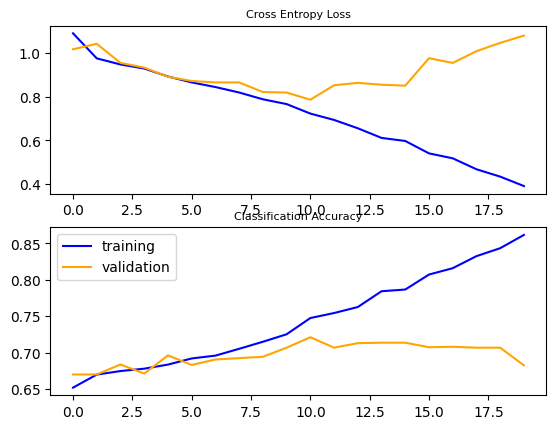

51/51 [==============================] - 0s 5ms/step


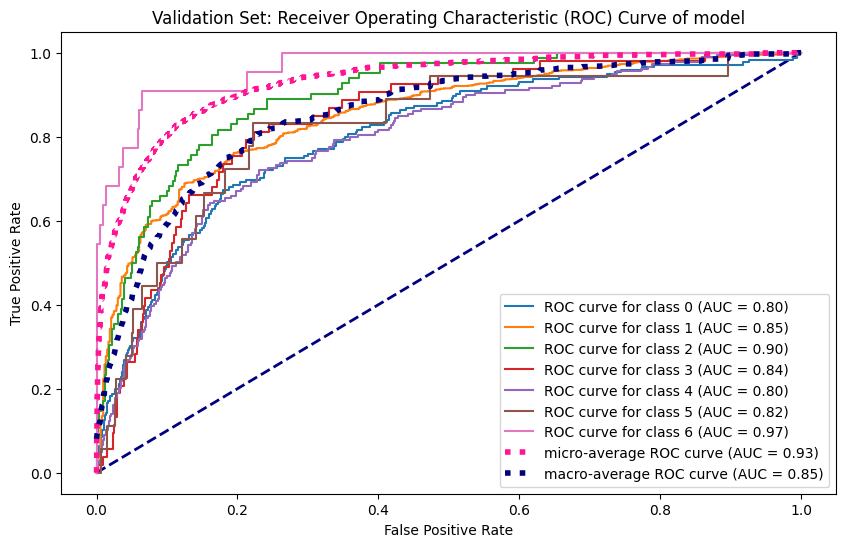

63/63 [==============================] - 1s 8ms/step


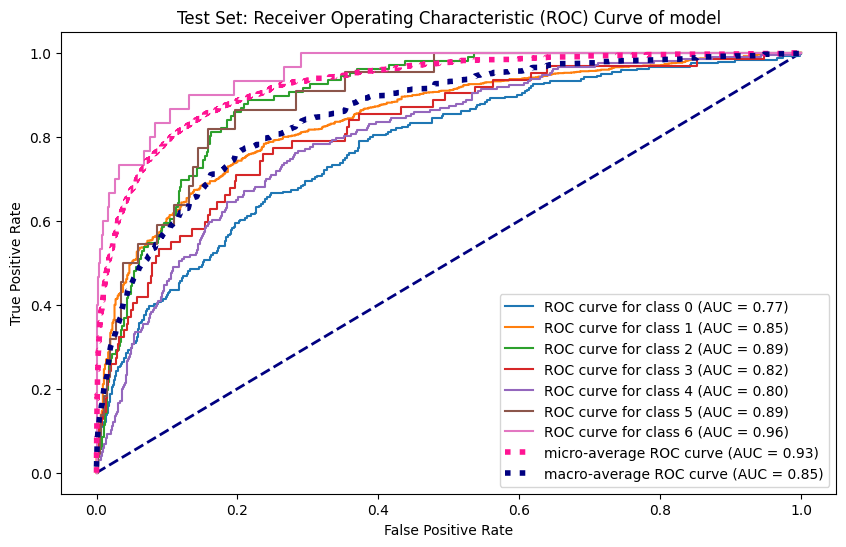

51/51 [==============================] - 0s 5ms/step


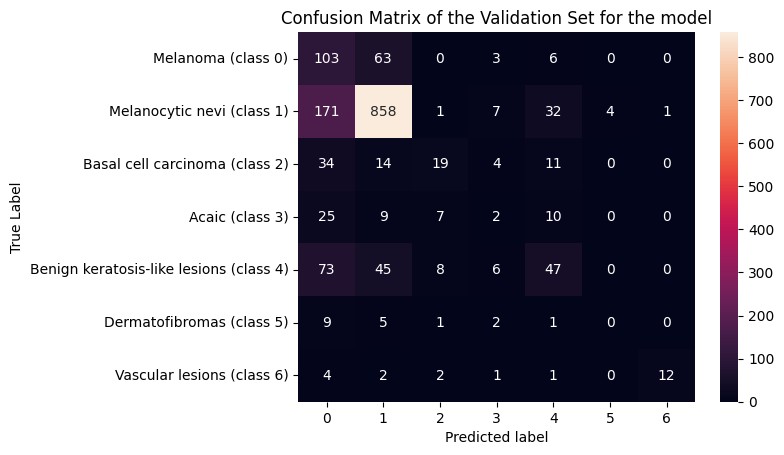

Validation accuracy: 0.649
63/63 [==============================] - 0s 5ms/step


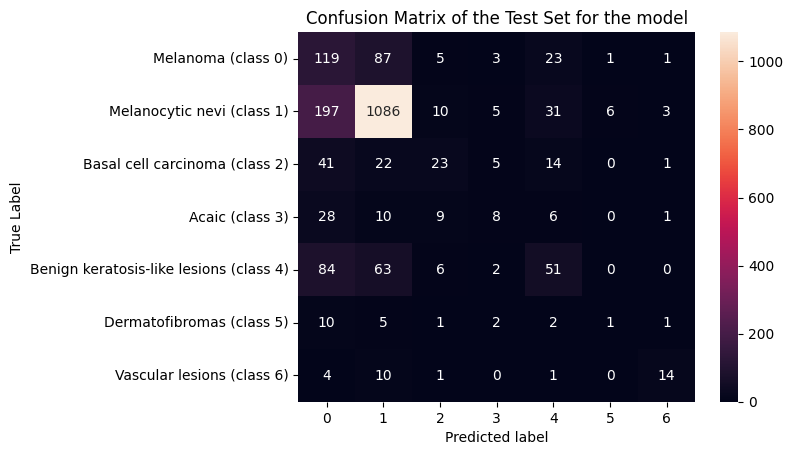

Test accuracy: 0.650
51/51 [==============================] - 0s 5ms/step
Validation Accuracy: 0.649
Validation F1 Score (unweighted mean): 0.365
Validation F1 Score (weighted mean): 0.657

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.347 |         0.779 |         0.589 |
|       1 |      0.829 |         0.739 |         0.799 |
|       2 |      0.317 |         0.988 |         0.232 |
|       3 |      0.051 |         0.985 |         0.038 |
|       4 |      0.328 |         0.957 |         0.263 |
|       5 |      0     |         0.997 |         0     |
|       6 |      0.686 |         0.999 |         0.545 |
63/63 [==============================] - 0s 5ms/step
Test Accuracy: 0.650
Test F1 Score (unweighted mean): 0.364
Test F1 Score (weighted mean): 0.654

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.33  |        

In [ ]:
# fit & summarize & display metrics
fit_plot(trilayered_adam_model, X_train= X_train, y_train= y_train, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 20)

# Combatting overfitting - Data Augmentation
Here we add three layers of keras Data Augmentation before input, which is usually used for preventing overfitting - a phenomenon observed above. In the plot we can see that overfitting has been effectively suppressed, since within-layer data augmentation is a good strategy for the machine not to overlearn certain features. Cross entropy loss decreased for the validation set, the minumum of which dropped from 0.9 to 0.8, while for the training set the curve follows that of validation. Same goes for classification accuracy; the model has much lower training accuracy without the expense of validation accuracy. There is slight increase in macro-ROC-AUC.

Class-specific F-1 score did not see a significant increase due to dataset imbalanced which remains unaddressed.

In [ ]:
# Build, train, fit, evaluate, assess
# We see there is significant
data_aug_model = build_model(X_train, use_data_aug_flip= True, use_data_aug_rot= True, use_data_aug_zoom= True)

Epoch 1/20
201/201 [==============================] - 7s 21ms/step - loss: 1.0399 - accuracy: 0.6683 - val_loss: 0.9799 - val_accuracy: 0.6700
Epoch 2/20
201/201 [==============================] - 3s 17ms/step - loss: 0.9679 - accuracy: 0.6733 - val_loss: 0.9602 - val_accuracy: 0.6744
Epoch 3/20
201/201 [==============================] - 3s 17ms/step - loss: 0.9469 - accuracy: 0.6748 - val_loss: 0.9275 - val_accuracy: 0.6987
Epoch 4/20
201/201 [==============================] - 3s 17ms/step - loss: 0.9264 - accuracy: 0.6823 - val_loss: 0.8932 - val_accuracy: 0.6962
Epoch 5/20
201/201 [==============================] - 3s 17ms/step - loss: 0.8985 - accuracy: 0.6786 - val_loss: 0.8733 - val_accuracy: 0.6800
Epoch 6/20
201/201 [==============================] - 3s 17ms/step - loss: 0.8766 - accuracy: 0.6873 - val_loss: 0.9360 - val_accuracy: 0.6881
Epoch 7/20
201/201 [==============================] - 3s 17ms/step - loss: 0.8661 - accuracy: 0.6878 - val_loss: 0.9637 - val_accuracy: 0.6762

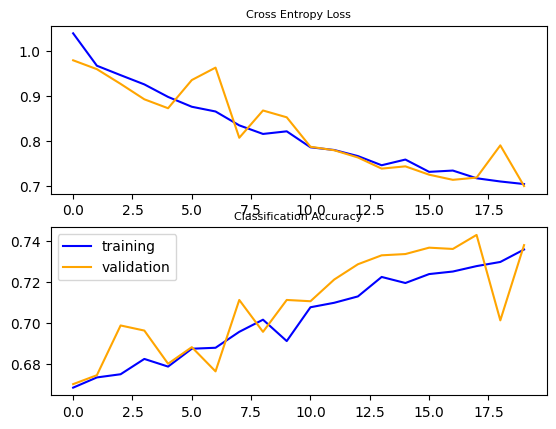

51/51 [==============================] - 0s 5ms/step


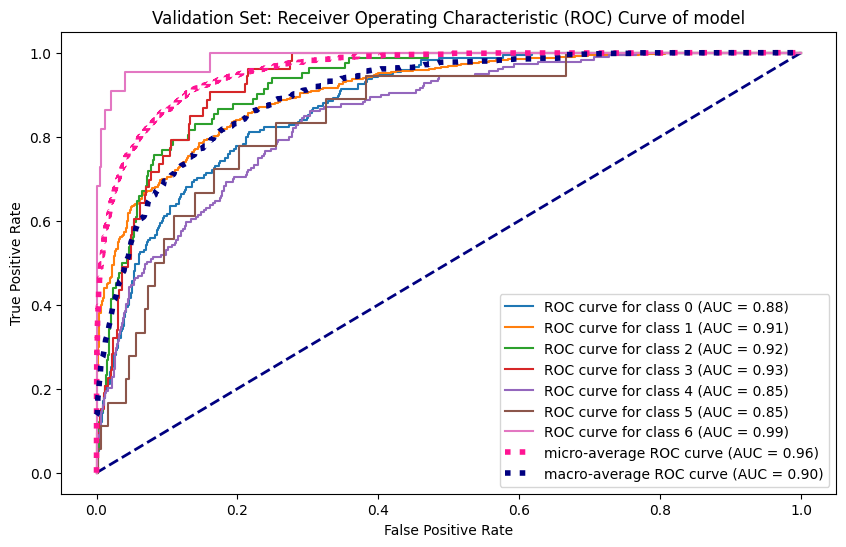

63/63 [==============================] - 0s 5ms/step


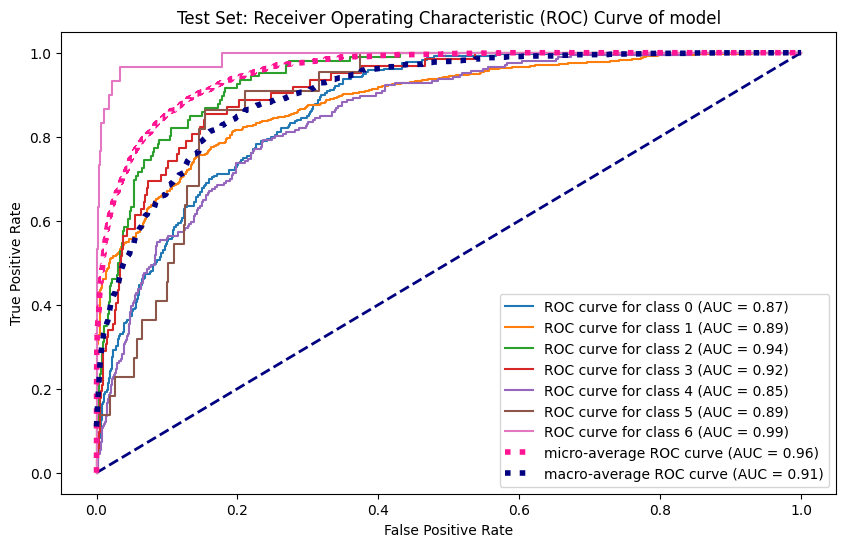

51/51 [==============================] - 0s 5ms/step


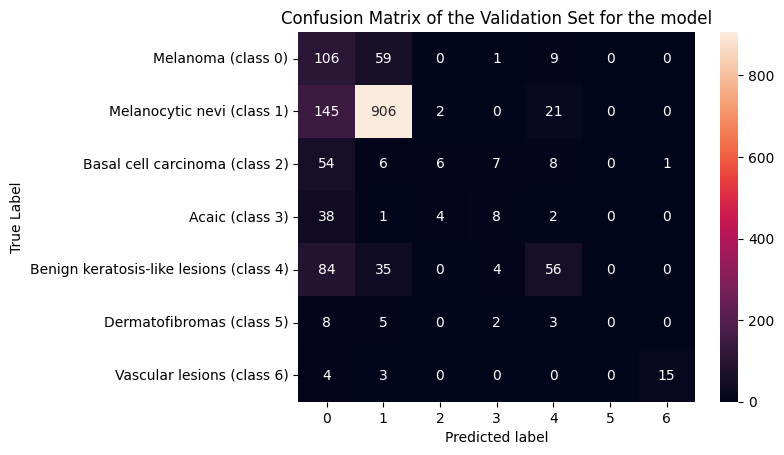

Validation accuracy: 0.684
63/63 [==============================] - 0s 5ms/step


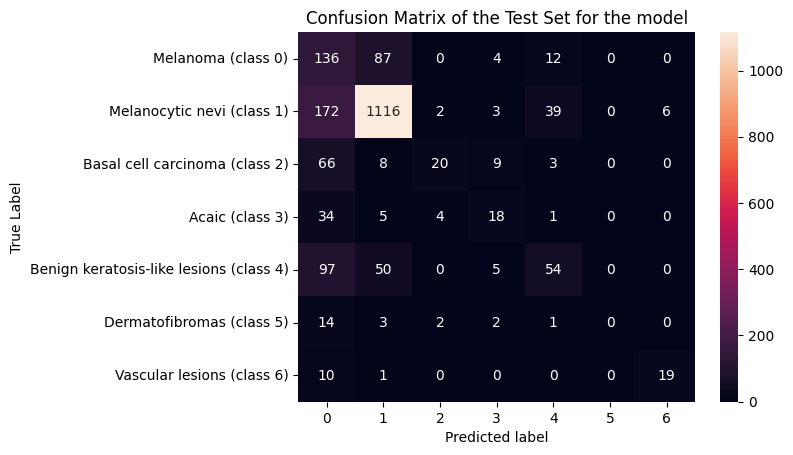

Test accuracy: 0.680
51/51 [==============================] - 0s 5ms/step
Validation Accuracy: 0.684
Validation F1 Score (unweighted mean): 0.392
Validation F1 Score (weighted mean): 0.688

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.345 |         0.767 |         0.606 |
|       1 |      0.867 |         0.794 |         0.844 |
|       2 |      0.128 |         0.996 |         0.073 |
|       3 |      0.213 |         0.991 |         0.151 |
|       4 |      0.403 |         0.97  |         0.313 |
|       5 |      0     |         1     |         0     |
|       6 |      0.789 |         0.999 |         0.682 |
63/63 [==============================] - 0s 5ms/step
Test Accuracy: 0.680
Test F1 Score (unweighted mean): 0.413
Test F1 Score (weighted mean): 0.686

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.354 |        

In [ ]:
# fit & summarize & display metrics
fit_plot(data_aug_model, X_train= X_train, y_train= y_train, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 20)

# Category balancing with Data Augmentation






##Implement Data Augmentation using RandomOverSampler
This is to oversample the dataset's minority clases through replication usingRandom Oversampler of imbalance leaarn library, after which within-layer real-time data augmentation is applied.

In [ ]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler
# reshaping
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# so that Randomoversampler can process y_train
y_train_categorical = np.argmax(y_train, axis=1)
ros = RandomOverSampler(random_state= 42, sampling_strategy='auto')
X_resampled, y_resampled_categorical = ros.fit_resample(X_train_reshaped, y_train_categorical)
# it creates the 2d array back
y_resampled = np.eye(y_train.shape[1])[y_resampled_categorical]
# reshape back so we can use them
original_shape = list(X_train.shape[1:])
X_resampled_images = X_resampled.reshape(-1, *original_shape)


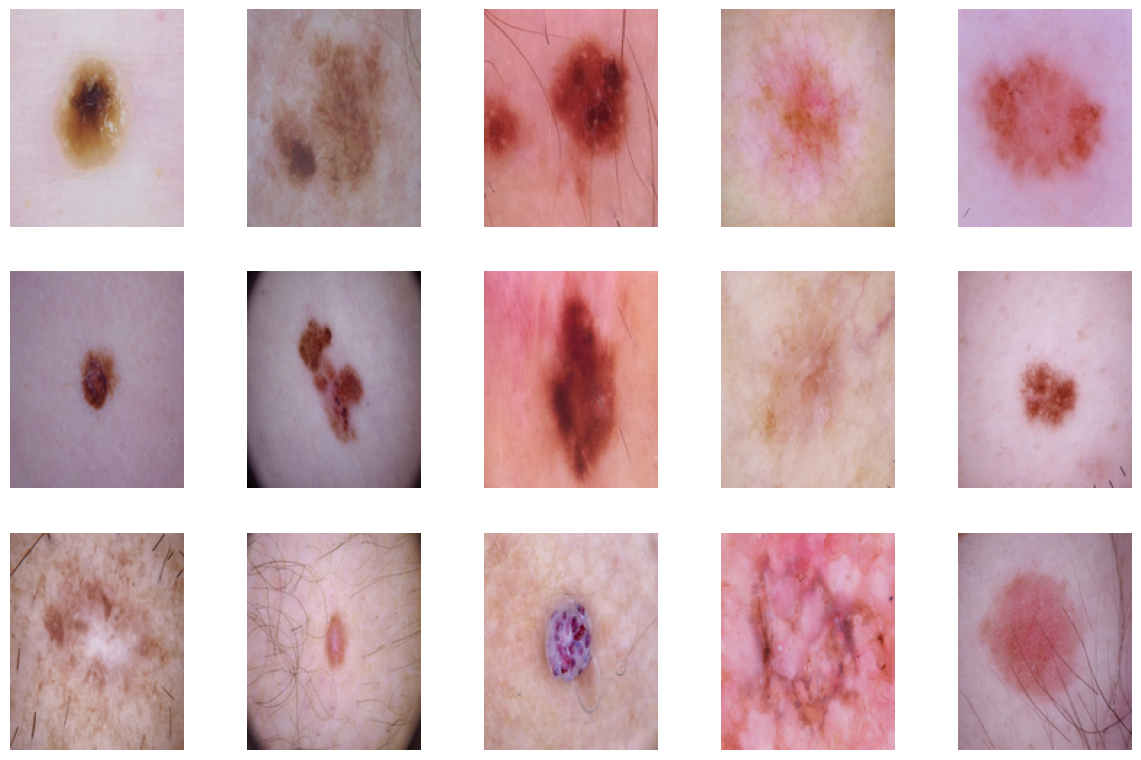

In [ ]:
import random
# show the images
# Set the random seed for reproducibility
random.seed(42)

# Randomly select 15 samples
selected_indices = random.sample(range(len(X_resampled_images)), 15)

# Create a figure to display the images
fig, axs = plt.subplots(3, 5, figsize=(12, 8))
fig.tight_layout()

# Iterate over the selected indices
for i, idx in enumerate(selected_indices):
    # Get the image and corresponding label
    image = X_resampled_images[idx]


    # Get the corresponding subplot axes
    ax = axs[i // 5, i % 5]

    # Display the image and label
    ax.imshow(image)
    ax.axis('off')

# Show the figure
plt.show()

In [ ]:
# We want to compare it with adam + in-layer data augmentation

oversampling_data_aug_model = build_model(X_val, use_data_aug_flip= 1, use_data_aug_rot= 1, use_data_aug_zoom= 1)

Epoch 1/20
940/940 [==============================] - 54s 43ms/step - loss: 1.4882 - accuracy: 0.3869 - val_loss: 1.2826 - val_accuracy: 0.5172
Epoch 2/20
940/940 [==============================] - 39s 41ms/step - loss: 1.1619 - accuracy: 0.5481 - val_loss: 1.1497 - val_accuracy: 0.5377
Epoch 3/20
940/940 [==============================] - 39s 41ms/step - loss: 0.9948 - accuracy: 0.6167 - val_loss: 1.0980 - val_accuracy: 0.5278
Epoch 4/20
940/940 [==============================] - 39s 41ms/step - loss: 0.8912 - accuracy: 0.6596 - val_loss: 0.9749 - val_accuracy: 0.5926
Epoch 5/20
940/940 [==============================] - 39s 41ms/step - loss: 0.8213 - accuracy: 0.6873 - val_loss: 0.9711 - val_accuracy: 0.6413
Epoch 6/20
940/940 [==============================] - 39s 41ms/step - loss: 0.7639 - accuracy: 0.7085 - val_loss: 1.2138 - val_accuracy: 0.5459
Epoch 7/20
940/940 [==============================] - 39s 41ms/step - loss: 0.7281 - accuracy: 0.7205 - val_loss: 0.9315 - val_accuracy:

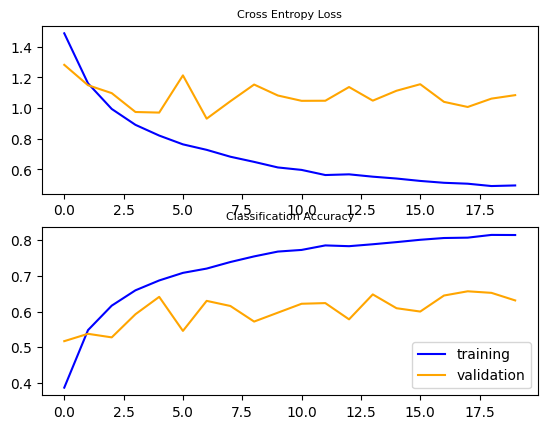

51/51 [==============================] - 1s 10ms/step


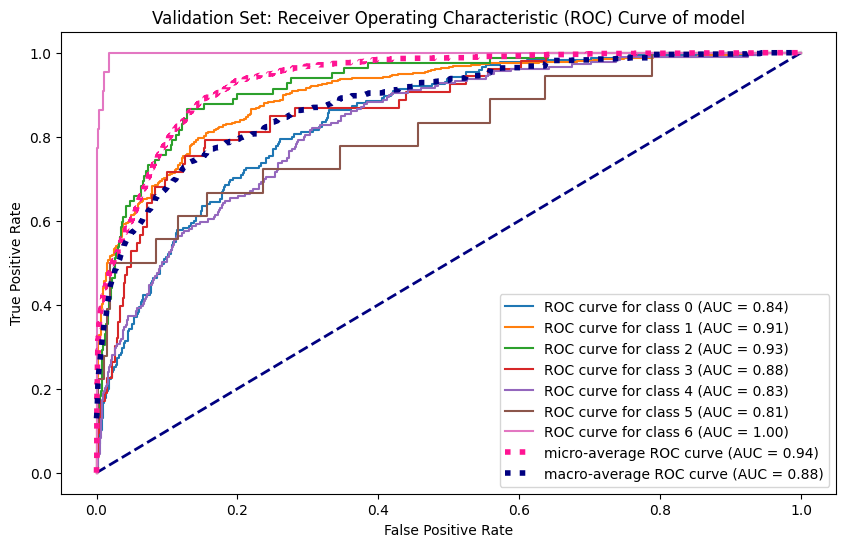

63/63 [==============================] - 1s 17ms/step


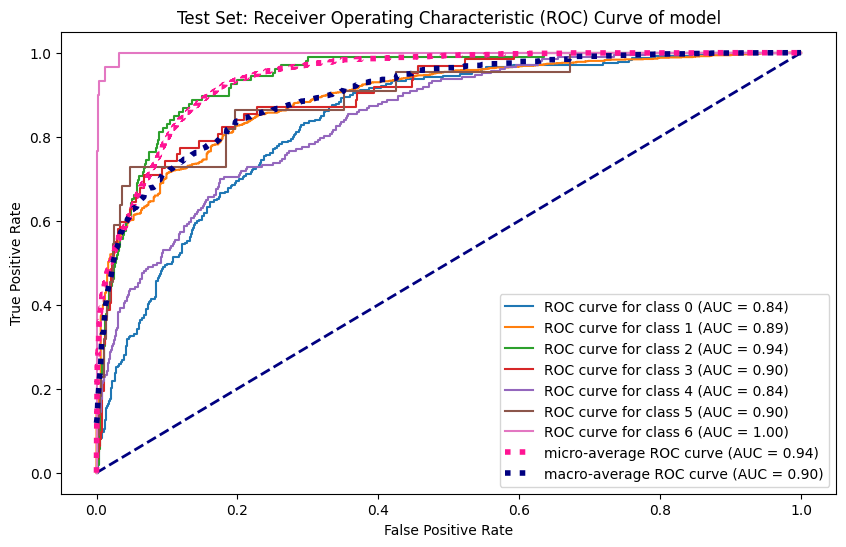

51/51 [==============================] - 1s 10ms/step


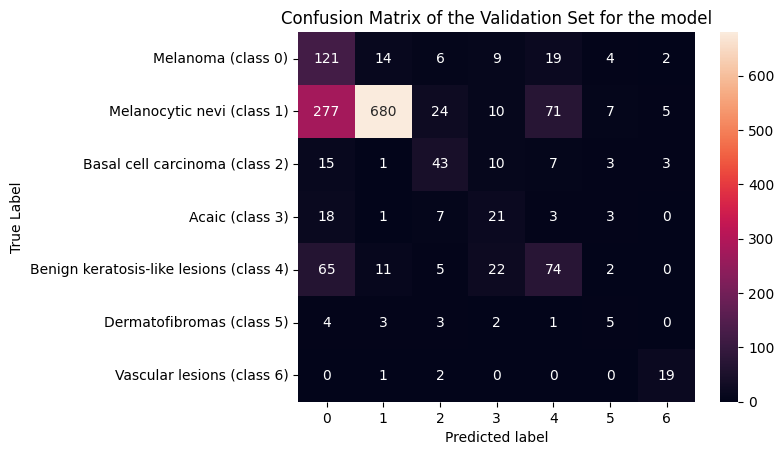

Validation accuracy: 0.601
63/63 [==============================] - 1s 10ms/step


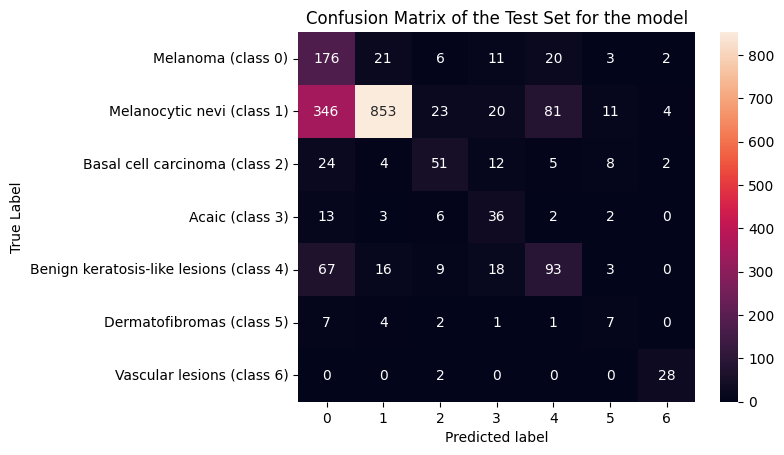

Test accuracy: 0.621
51/51 [==============================] - 1s 10ms/step
Validation Accuracy: 0.601
Validation F1 Score (unweighted mean): 0.479
Validation F1 Score (weighted mean): 0.646

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.359 |         0.735 |         0.691 |
|       1 |      0.762 |         0.941 |         0.633 |
|       2 |      0.5   |         0.969 |         0.524 |
|       3 |      0.331 |         0.966 |         0.396 |
|       4 |      0.418 |         0.929 |         0.413 |
|       5 |      0.238 |         0.988 |         0.278 |
|       6 |      0.745 |         0.994 |         0.864 |
63/63 [==============================] - 1s 10ms/step
Test Accuracy: 0.621
Test F1 Score (unweighted mean): 0.524
Test F1 Score (weighted mean): 0.660

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.404 |      

In [ ]:
# fit & summarize & display metrics
fit_plot(oversampling_data_aug_model, X_train= X_resampled_images, y_train= y_resampled, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 20, batch_size= 32)

## Implement Data Augmentation using ImageDataGen



In [ ]:
list_of_names = ['Melanoma', 'Melanocytic nevi',
          'Basal cell carcinoma', 'Acaic',
          'Benign keratosis-like lesions',
          'Dermatofibromas', 'Vascular lesions']
names_to_skip = ['Melanocytic nevi']
# Data here is post-split and pre-scaling


def specific_class_array(class_name, labels= train_labels, list_of_names = list_of_names):
    list_of_names = list_of_names
    ind = list_of_names.index(class_name)
    train_labels_df = pd.DataFrame(labels)
    train_index_list = train_labels_df[train_labels_df.iloc[:, ind] == 1].index.tolist()
    train_tensors = [train_images[k] for k in train_index_list]
    train_tensor_labels = [train_labels[k] for k in train_index_list]
    train_tensors_array = np.array(train_tensors)
    train_tensor_labels_array = np.array(train_tensor_labels)
    return train_index_list, train_tensors_array, train_tensor_labels_array # This generates a dataset that is unique to a class within the split training set

In [ ]:
# here we have got class-specific index lists, tensor arrays, label arrays stored in dictionaries
tensor_arrays = {}
all_labels = {}
index_dict = {}
for name in list_of_names:
    index_dict[name], tensor_arrays[name], all_labels[name] = specific_class_array(name)



In [ ]:
from keras.preprocessing.image import ImageDataGenerator
save_dir = '/content/drive/MyDrive/Deep_Learning/Assignment/image_aug'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Above we make a folder where we store files for class-specific image (tensor)
# and label files
# target_count = 5000
datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.4,
        height_shift_range=0.4,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')
target_count = 1000




In [ ]:
def image_augmentor_gen(image_of_class, labels_of_class):
    num_to_generate = - len(image_of_class) + target_count
    i = 0
    for img, label in zip(image_of_class, labels_of_class):
        img = img.reshape((1,) + img.shape)
        for batch in datagen.flow(img, batch_size=1):
            yield (batch[0], label)
            i += 1
            if i >= num_to_generate:
                break

In [ ]:
for key in tensor_arrays:
    if key in names_to_skip:
        continue
        # We do not generate these classes
    else:
        gen = image_augmentor_gen(tensor_arrays[key], all_labels[key])

        augmented_images = []
        augmented_labels = []
        for img, label in gen:
            augmented_images.append(img)
            augmented_labels.append(label)

        augmented_images = np.array(augmented_images)
        augmented_labels = np.array(augmented_labels)

        # Save the files to free up memory
        np.save(f'{save_dir}/{key}_augmented_images.npy', augmented_images)
        np.save(f'{save_dir}/{key}_augmented_labels.npy', augmented_labels)
        print(os.path.exists(f'{save_dir}/{key}_augmented_images.npy'))
        del augmented_images, augmented_labels
        import gc
        gc.collect()

True
True
True
True
True
True


In [ ]:
augmented_data_images_list = []
augmented_data_labels_list = []

# read the data from files
for key in [item for item in list_of_names if item not in names_to_skip]:
    augmented_data_images_list.append(np.load(f'{save_dir}/{key}_augmented_images.npy'))
    augmented_data_labels_list.append(np.load(f'{save_dir}/{key}_augmented_labels.npy', allow_pickle=True))

# Undersampling
import random
# Undersample Melanocytic nevi
random.seed(42)
# We randomly choose some of the data indices
random_data_indices = random.sample(range(len(tensor_arrays['Melanocytic nevi'])), target_count)
augmented_data_images_list.append(tensor_arrays['Melanocytic nevi'][random_data_indices])
augmented_data_labels_list.append(all_labels['Melanocytic nevi'][random_data_indices])

# list_of_no_change = ['Melanoma', 'Benign keratosis-like lesions']
# for key in ['Melanoma', 'Benign keratosis-like lesions']:
    #augmented_data_images_list.append(tensor_arrays[key])
    #augmented_data_labels_list.append(all_labels[key])


# This is for training!
augmented_data_images = np.concatenate(augmented_data_images_list, axis=0)
augmented_data_labels = np.concatenate(augmented_data_labels_list, axis=0)

In [ ]:
augmented_data_labels.sum(axis = 0)

array([999.0, 1000.0, 999.0, 999.0, 999.0, 999.0, 999.0], dtype=object)

In [ ]:

# Normalize your image data to floating point numbers between 0 and 1
X_train_aug = augmented_data_images.astype('float32')/ 255.0
X_test = test_images.astype('float32')/ 255.0
X_val = val_images.astype('float32')/ 255.0

#Convert also the target labels to floats.
y_train_aug = augmented_data_labels.astype('float32')
y_test = test_labels.astype('float32')
y_val = val_labels.astype('float32')

In [ ]:
y_train_aug.sum(axis = 0)

array([ 999., 1000.,  999.,  999.,  999.,  999.,  999.], dtype=float32)

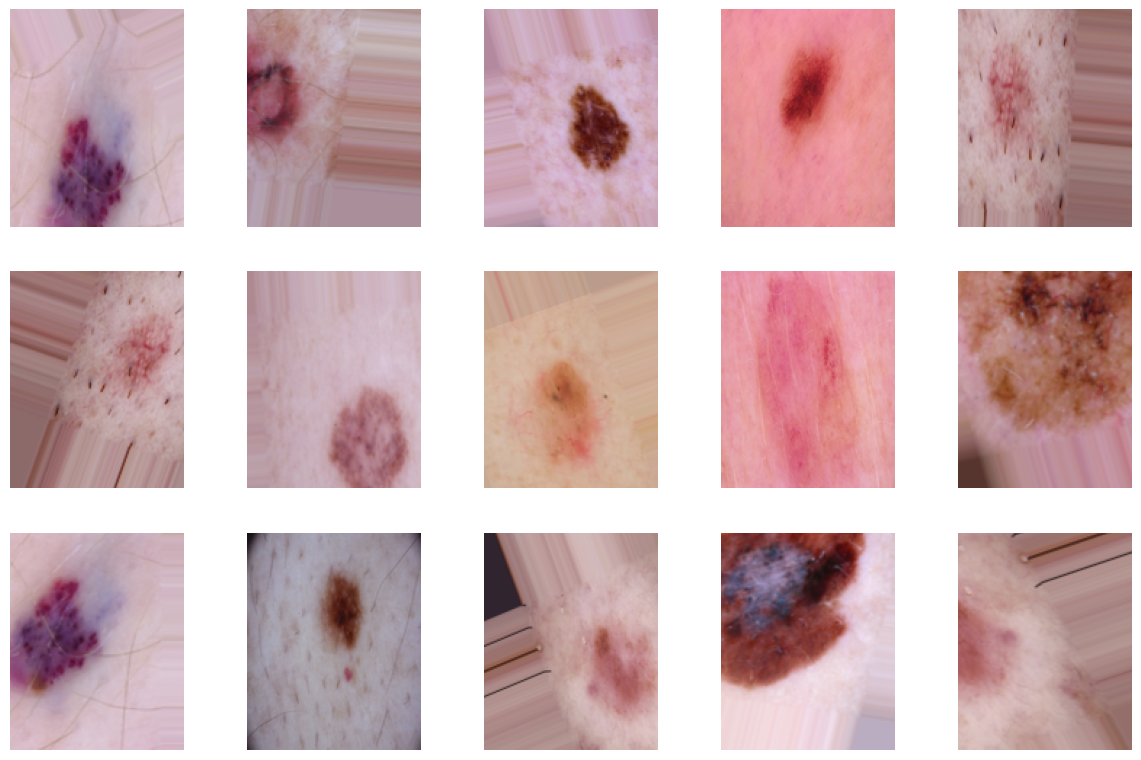

In [ ]:
import random
# show the images
# Set the random seed for reproducibility
random.seed(42)

# Randomly select 15 samples
selected_indices = random.sample(range(len(X_train_aug)), 15)

# Create a figure to display the images
fig, axs = plt.subplots(3, 5, figsize=(12, 8))
fig.tight_layout()

# Iterate over the selected indices
for i, idx in enumerate(selected_indices):
    # Get the image and corresponding label
    image = X_train_aug[idx]


    # Get the corresponding subplot axes
    ax = axs[i // 5, i % 5]

    # Display the image and label
    ax.imshow(image)
    ax.axis('off')

# Show the figure
plt.show()

In [ ]:
# Build, train, fit, evaluate, assess
# We see there is significant
pre_data_aug_model = build_model(X_train_aug, optimizer= 'adam')

Epoch 1/20
219/219 [==============================] - 17s 21ms/step - loss: 1.5735 - accuracy: 0.3775 - val_loss: 1.2475 - val_accuracy: 0.5889
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.9656 - accuracy: 0.6639 - val_loss: 1.1900 - val_accuracy: 0.6606
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.8237 - accuracy: 0.7055 - val_loss: 1.1497 - val_accuracy: 0.6051
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.7341 - accuracy: 0.7491 - val_loss: 1.2383 - val_accuracy: 0.6195
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.6183 - accuracy: 0.7874 - val_loss: 1.1567 - val_accuracy: 0.6463
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.5455 - accuracy: 0.8120 - val_loss: 1.1374 - val_accuracy: 0.6550
Epoch 7/20
219/219 [==============================] - 3s 16ms/step - loss: 0.4638 - accuracy: 0.8323 - val_loss: 1.1883 - val_accuracy: 0.675

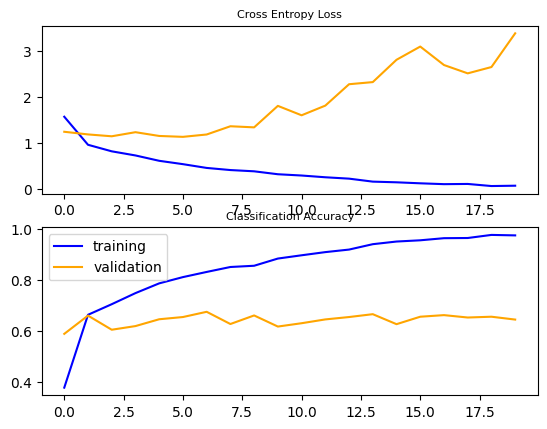

51/51 [==============================] - 0s 5ms/step


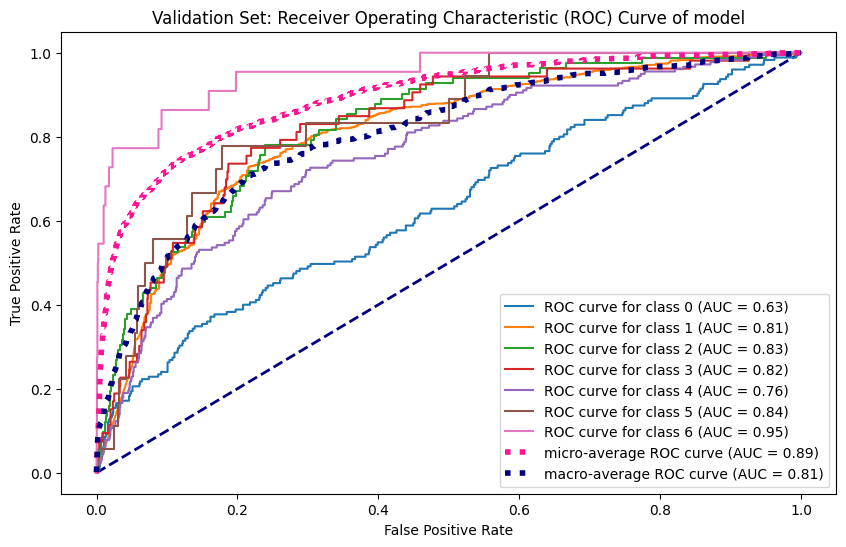

63/63 [==============================] - 0s 7ms/step


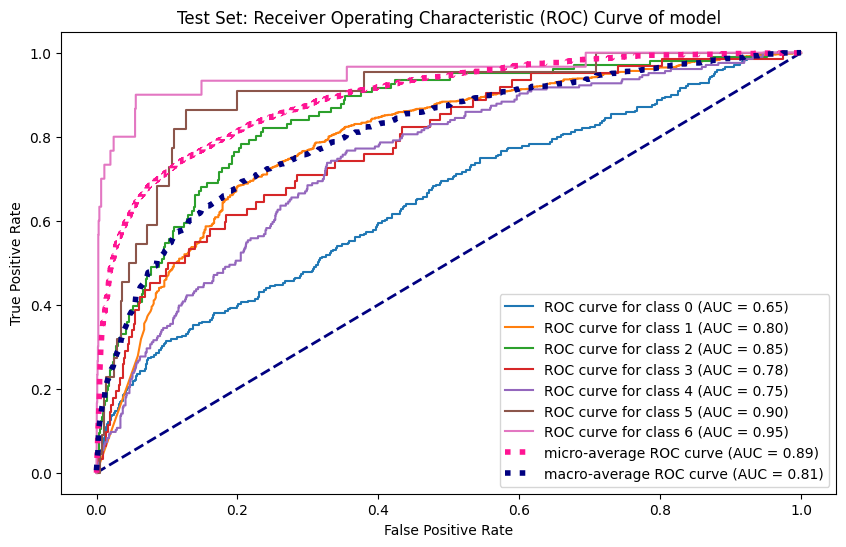

51/51 [==============================] - 0s 5ms/step


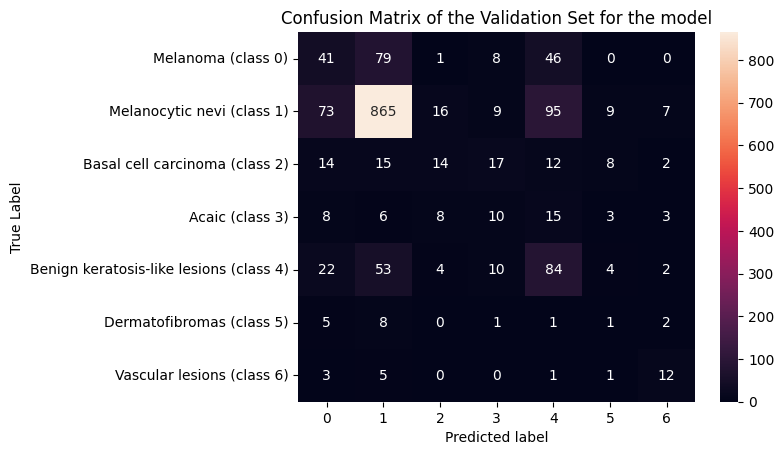

Validation accuracy: 0.641
63/63 [==============================] - 0s 5ms/step


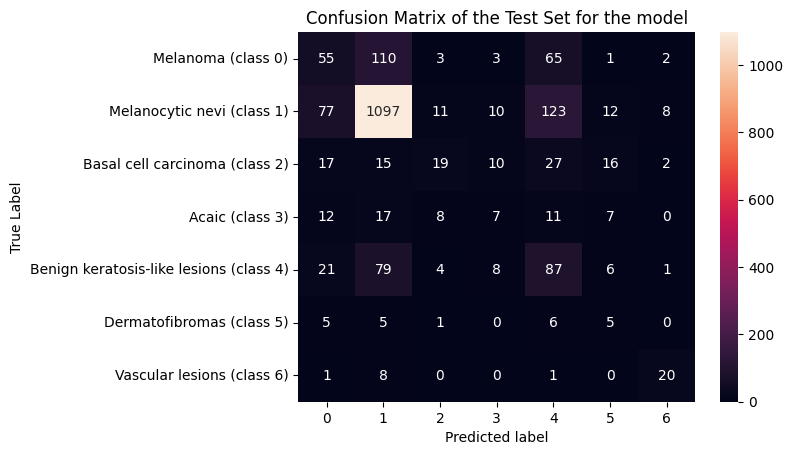

Test accuracy: 0.644
51/51 [==============================] - 0s 5ms/step
Validation Accuracy: 0.641
Validation F1 Score (unweighted mean): 0.341
Validation F1 Score (weighted mean): 0.645

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.24  |         0.912 |         0.234 |
|       1 |      0.822 |         0.686 |         0.805 |
|       2 |      0.224 |         0.981 |         0.171 |
|       3 |      0.185 |         0.971 |         0.189 |
|       4 |      0.388 |         0.881 |         0.469 |
|       5 |      0.045 |         0.984 |         0.056 |
|       6 |      0.48  |         0.99  |         0.545 |
63/63 [==============================] - 0s 5ms/step
Test Accuracy: 0.644
Test F1 Score (unweighted mean): 0.369
Test F1 Score (weighted mean): 0.643

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.258 |        

In [ ]:
fit_plot(pre_data_aug_model, X_train= X_train_aug, y_train= y_train_aug, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 20, batch_size= 32, threshold = 0.5)

In [ ]:
adamax_pre_data_aug_model = build_model(X_train_aug, optimizer= 'adamax')

Epoch 1/20
219/219 [==============================] - 17s 22ms/step - loss: 1.4043 - accuracy: 0.4548 - val_loss: 1.3026 - val_accuracy: 0.5465
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.9633 - accuracy: 0.6514 - val_loss: 1.1919 - val_accuracy: 0.6070
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.8750 - accuracy: 0.6962 - val_loss: 1.2094 - val_accuracy: 0.6126
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.7854 - accuracy: 0.7378 - val_loss: 1.1924 - val_accuracy: 0.6051
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.6851 - accuracy: 0.7707 - val_loss: 1.2742 - val_accuracy: 0.6544
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.6425 - accuracy: 0.7887 - val_loss: 1.2794 - val_accuracy: 0.6294
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.5883 - accuracy: 0.7980 - val_loss: 1.3032 - val_accuracy: 0.573

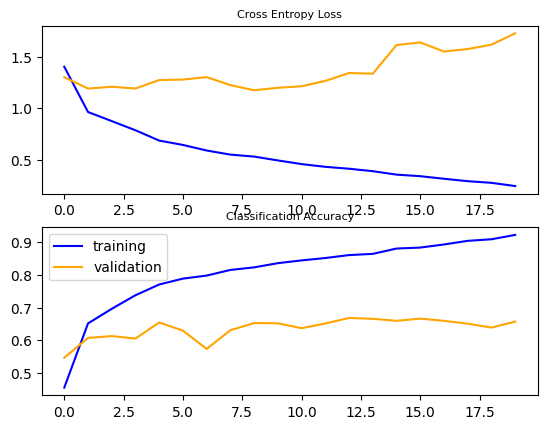

51/51 [==============================] - 0s 5ms/step


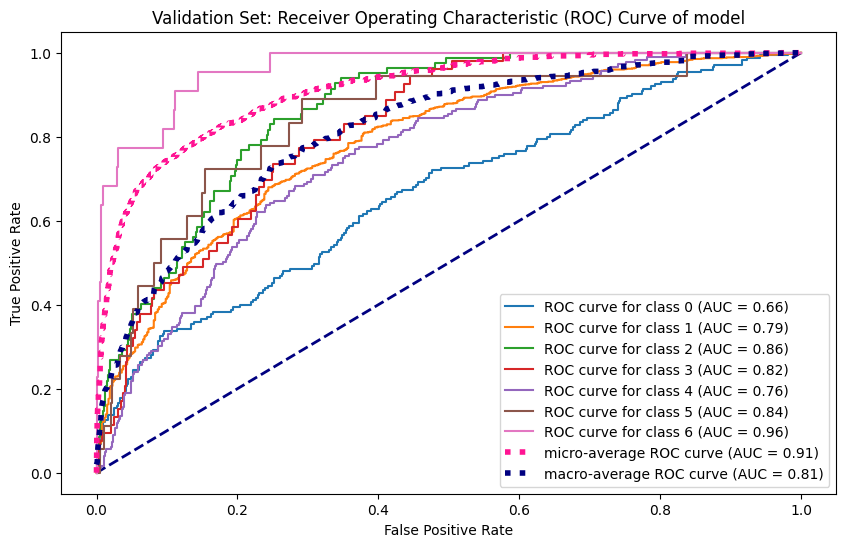

63/63 [==============================] - 0s 7ms/step


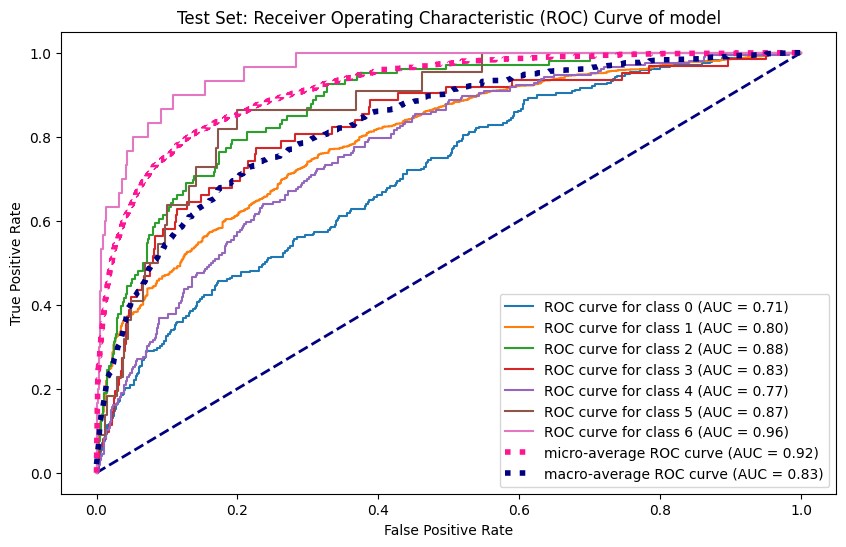

51/51 [==============================] - 0s 5ms/step


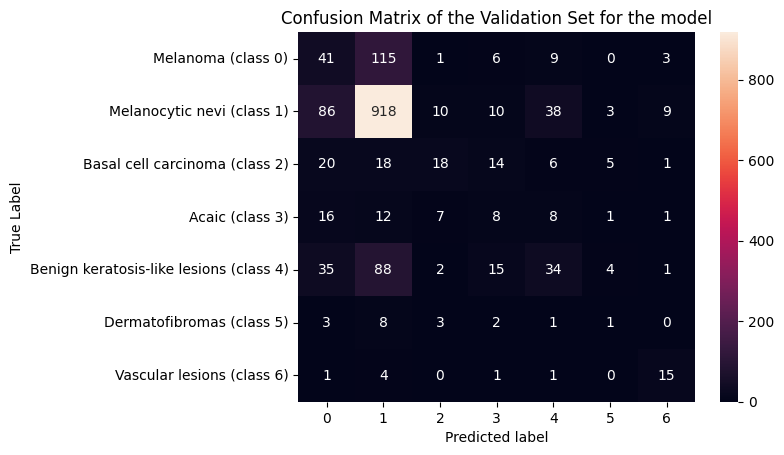

Validation accuracy: 0.646
63/63 [==============================] - 0s 5ms/step


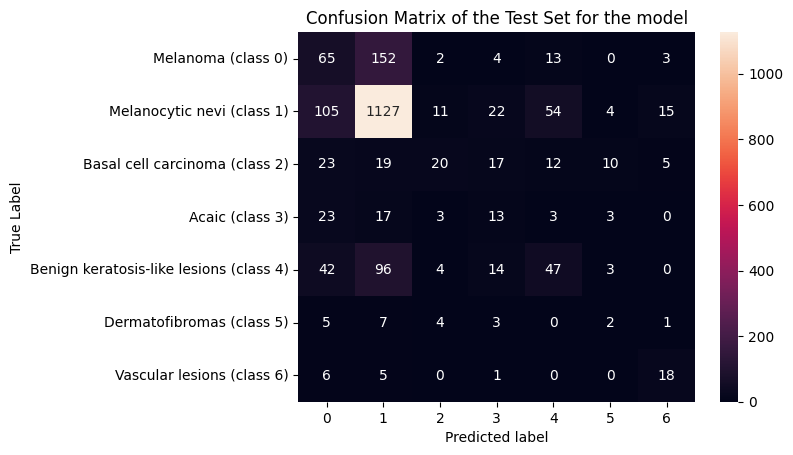

Test accuracy: 0.645
51/51 [==============================] - 0s 5ms/step
Validation Accuracy: 0.646
Validation F1 Score (unweighted mean): 0.338
Validation F1 Score (weighted mean): 0.630

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.218 |         0.887 |         0.234 |
|       1 |      0.821 |         0.537 |         0.855 |
|       2 |      0.293 |         0.985 |         0.22  |
|       3 |      0.147 |         0.969 |         0.151 |
|       4 |      0.246 |         0.956 |         0.19  |
|       5 |      0.062 |         0.992 |         0.056 |
|       6 |      0.577 |         0.991 |         0.682 |
63/63 [==============================] - 0s 5ms/step
Test Accuracy: 0.645
Test F1 Score (unweighted mean): 0.343
Test F1 Score (weighted mean): 0.633

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.256 |        

In [ ]:
fit_plot(adamax_pre_data_aug_model, X_train= X_train_aug, y_train= y_train_aug, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 20, batch_size= 32, threshold = 0.5)

# Transfer Learning Model
https://keras.io/guides/transfer_learning/





In [ ]:
from google.colab import runtime
runtime.unassign()

##VGG

In [ ]:
from keras.applications.vgg16 import VGG16
def build_vgg(input= X_train):
		# load model without output layer and specify a new input shape for images
		vgg_model = VGG16(include_top=False, input_shape=input.shape[1:])
		# mark loaded layers as not trainable
		for layer in vgg_model.layers:
				layer.trainable = False

		from tensorflow.keras import layers
		from keras.models import Model

		# add new classifier layers
		#add flatten layer
		flat1 = layers.Flatten()(vgg_model.layers[-1].output)
		#add Dense layer
		class1 = layers.Dense(128, activation='relu')(flat1)
		#add output layer with softmax activation
		output = layers.Dense(7, activation='softmax')(class1)
		# define new model
		vgg_model = Model(inputs=vgg_model.inputs, outputs=output)

		return vgg_model

In [ ]:
# build model
vgg_model= build_vgg()
# compile model
vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/25
201/201 [==============================] - 8s 30ms/step - loss: 0.9378 - accuracy: 0.6836 - val_loss: 0.8564 - val_accuracy: 0.7012
Epoch 2/25
201/201 [==============================] - 5s 23ms/step - loss: 0.7674 - accuracy: 0.7308 - val_loss: 0.7664 - val_accuracy: 0.7218
Epoch 3/25
201/201 [==============================] - 5s 23ms/step - loss: 0.6944 - accuracy: 0.7547 - val_loss: 0.7574 - val_accuracy: 0.7336
Epoch 4/25
201/201 [==============================] - 5s 23ms/step - loss: 0.6429 - accuracy: 0.7683 - val_loss: 0.7444 - val_accuracy: 0.7405
Epoch 5/25
201/201 [==============================] - 5s 24ms/step - loss: 0.6004 - accuracy: 0.7831 - val_loss: 0.8182 - val_accuracy: 0.7099
Epoch 6/25
201/201 [==============================] - 5s 23ms/step - loss: 0.5782 - accuracy: 0.7933 - val_loss: 0.9043 - val_accuracy: 0.7162
Epoch 7/25
201/201 [==============================] - 5s 23ms/step - loss: 0.5636 - accuracy: 0.7989 - val_loss: 0.7554 - val_accuracy: 0.7473

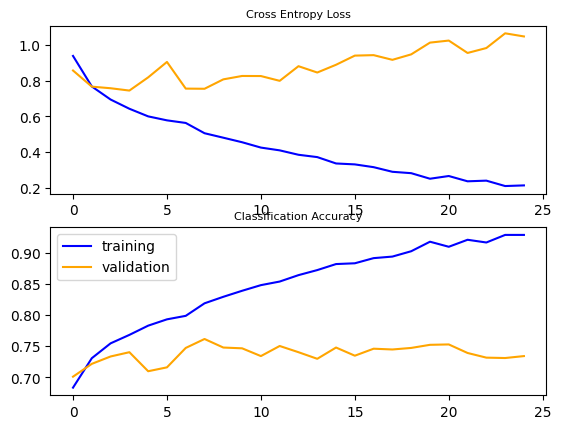

51/51 [==============================] - 1s 16ms/step


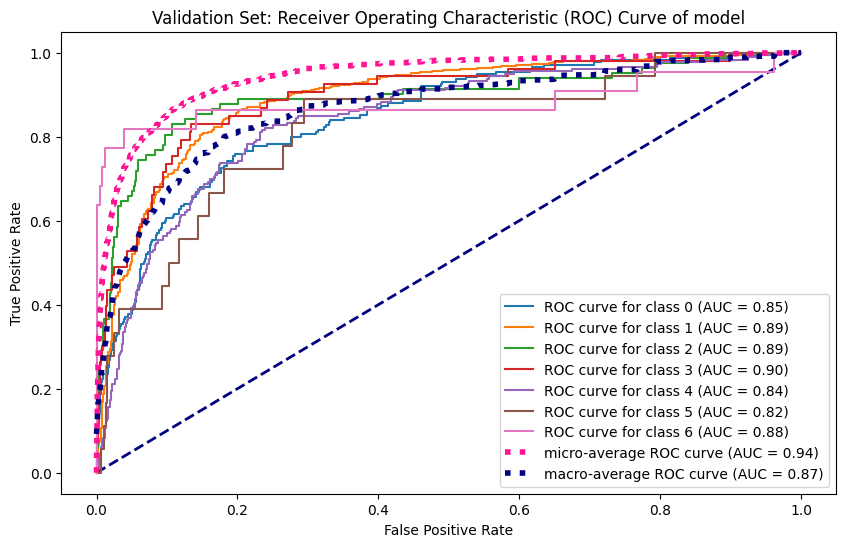

63/63 [==============================] - 1s 24ms/step


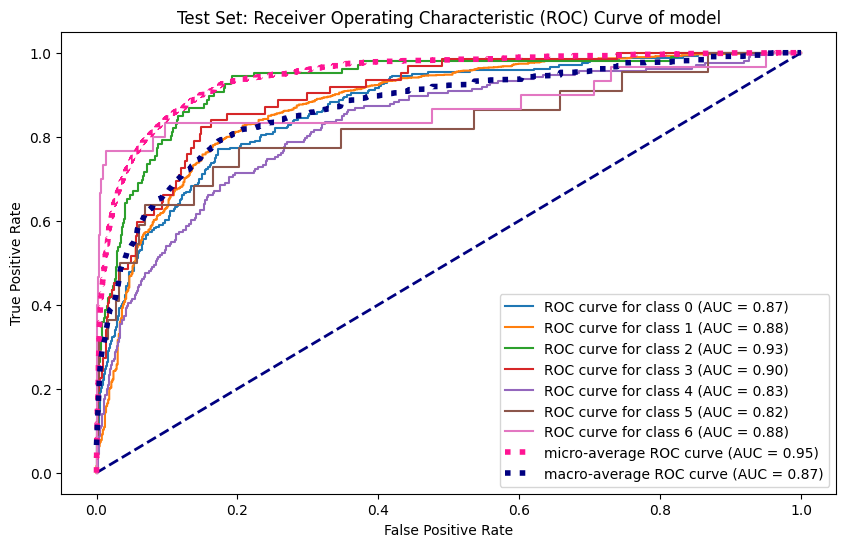

51/51 [==============================] - 1s 16ms/step


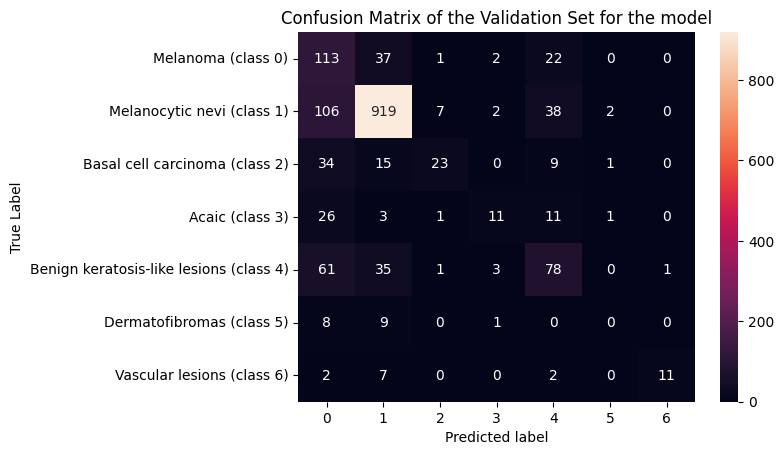

Validation accuracy: 0.721
63/63 [==============================] - 1s 16ms/step


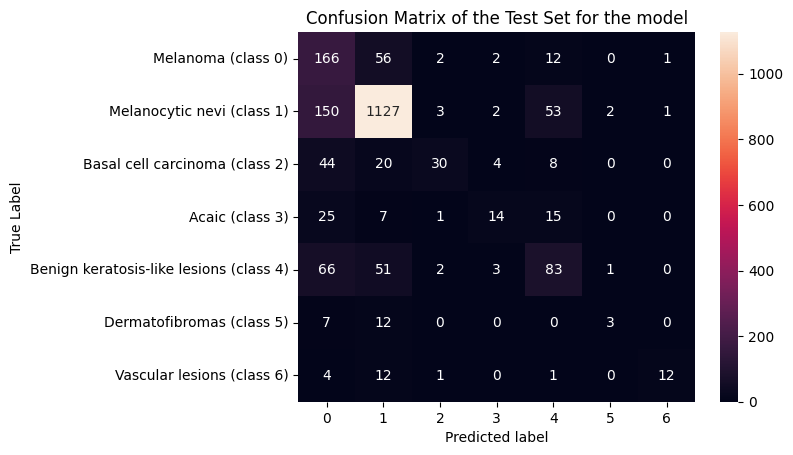

Test accuracy: 0.716
51/51 [==============================] - 1s 16ms/step
Validation Accuracy: 0.721
Validation F1 Score (unweighted mean): 0.446
Validation F1 Score (weighted mean): 0.725

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.43  |         0.834 |         0.646 |
|       1 |      0.876 |         0.8   |         0.856 |
|       2 |      0.4   |         0.993 |         0.28  |
|       3 |      0.306 |         0.995 |         0.208 |
|       4 |      0.46  |         0.942 |         0.436 |
|       5 |      0     |         0.997 |         0     |
|       6 |      0.647 |         0.999 |         0.5   |
63/63 [==============================] - 1s 16ms/step
Test Accuracy: 0.716
Test F1 Score (unweighted mean): 0.467
Test F1 Score (weighted mean): 0.718

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.474 |      

In [ ]:
# fit & summarize & display metrics
fit_plot(vgg_model, X_train= X_train, y_train= y_train, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 25, batch_size= 32)

##Resnet

In [ ]:
from keras.applications.resnet50 import ResNet50
# load model without output layer and specify a new input shape for images
resnet_model = ResNet50(include_top=False, weights="imagenet",input_shape=X_train.shape[1:])
# mark loaded layers as not trainable
for layer in resnet_model.layers:
	layer.trainable = False

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
from tensorflow.keras import layers
from keras.models import Model

# add new classifier layers
#add flatten layer
flat1 = layers.Flatten()(resnet_model.layers[-1].output)
#add Dense layer
class1 = layers.Dense(64, activation='relu')(flat1)
#add output layer with softmax activation
output = layers.Dense(7, activation='softmax')(class1)
# define new model
resnet_model = Model(inputs=resnet_model.inputs, outputs=output)


In [ ]:
# compile model
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/25
201/201 [==============================] - 10s 32ms/step - loss: 1.1531 - accuracy: 0.6695 - val_loss: 1.1243 - val_accuracy: 0.6706
Epoch 2/25
201/201 [==============================] - 4s 22ms/step - loss: 1.1006 - accuracy: 0.6726 - val_loss: 1.1733 - val_accuracy: 0.6432
Epoch 3/25
201/201 [==============================] - 4s 22ms/step - loss: 1.0828 - accuracy: 0.6733 - val_loss: 1.0539 - val_accuracy: 0.6712
Epoch 4/25
201/201 [==============================] - 4s 22ms/step - loss: 1.0545 - accuracy: 0.6770 - val_loss: 1.0746 - val_accuracy: 0.6750
Epoch 5/25
201/201 [==============================] - 4s 22ms/step - loss: 1.0587 - accuracy: 0.6765 - val_loss: 1.0525 - val_accuracy: 0.6750
Epoch 6/25
201/201 [==============================] - 4s 22ms/step - loss: 1.0367 - accuracy: 0.6778 - val_loss: 1.0040 - val_accuracy: 0.6806
Epoch 7/25
201/201 [==============================] - 4s 22ms/step - loss: 1.0187 - accuracy: 0.6792 - val_loss: 1.0338 - val_accuracy: 0.680

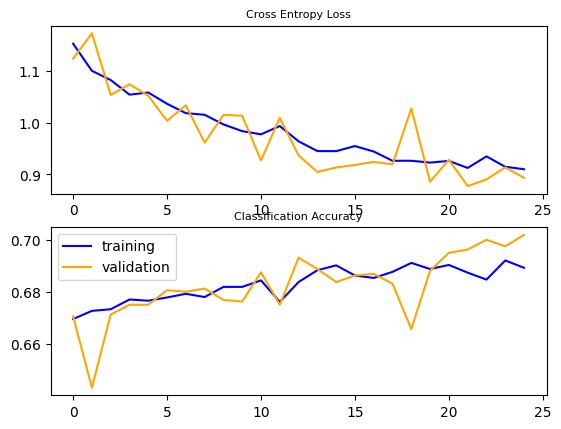

51/51 [==============================] - 2s 15ms/step


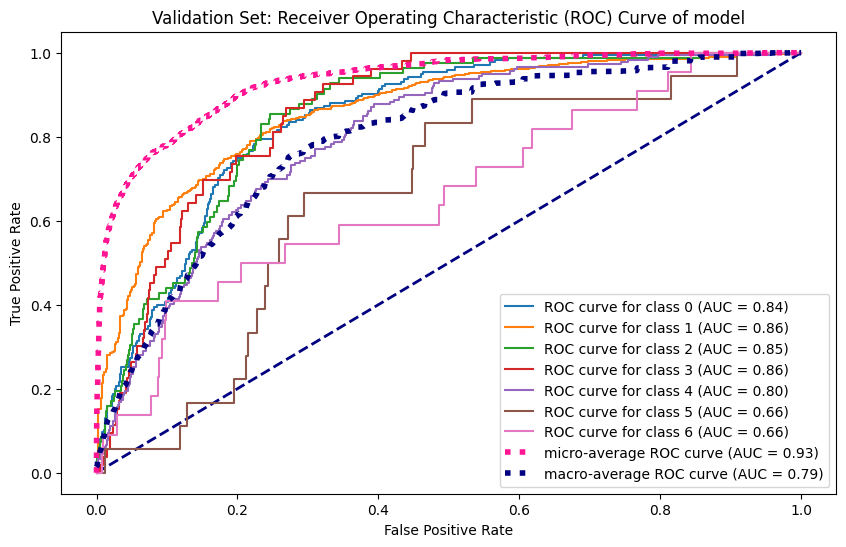

63/63 [==============================] - 1s 19ms/step


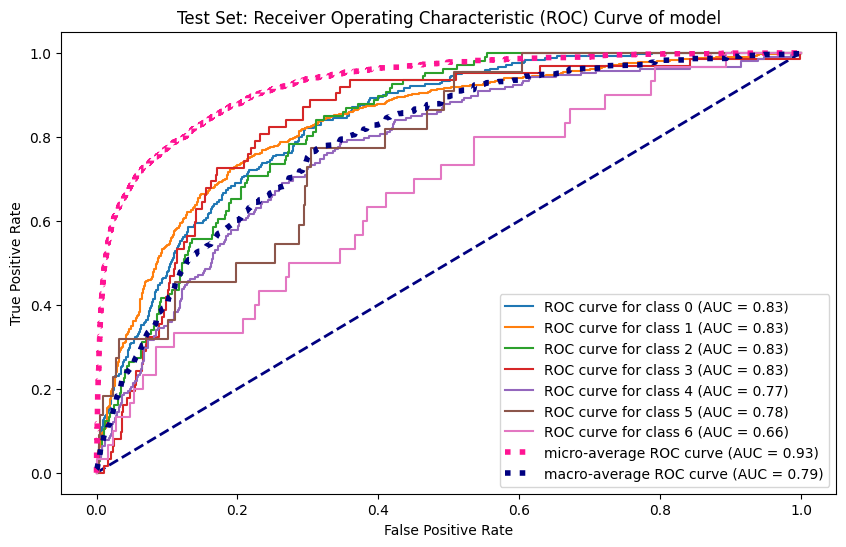

51/51 [==============================] - 1s 15ms/step


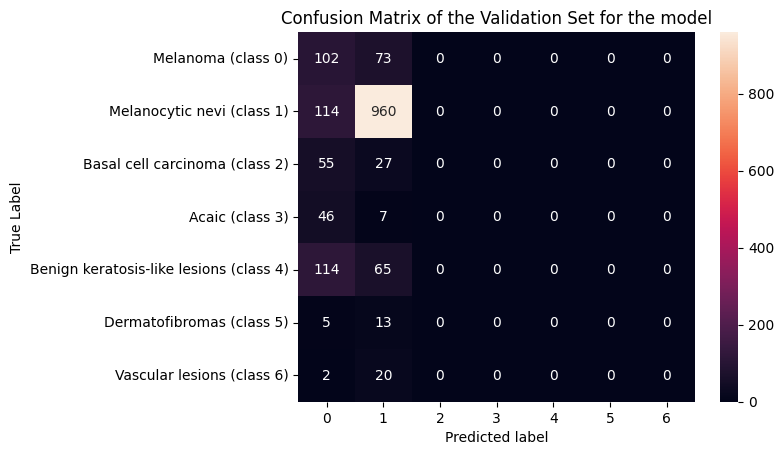

Validation accuracy: 0.663
63/63 [==============================] - 1s 15ms/step


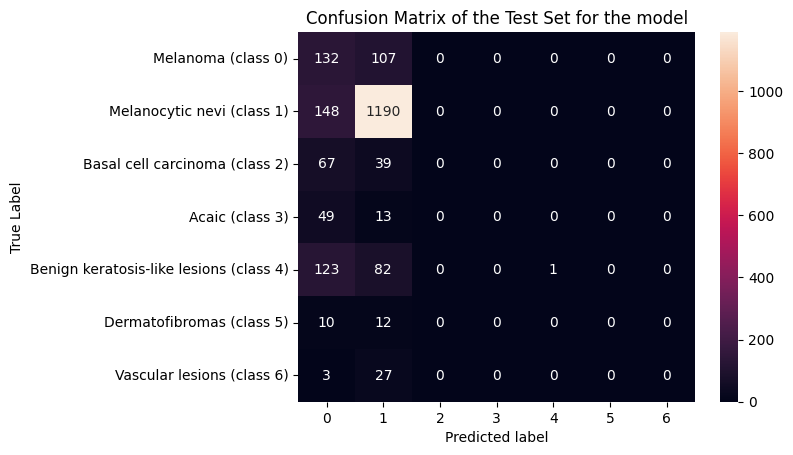

Test accuracy: 0.661
51/51 [==============================] - 1s 15ms/step
Validation Accuracy: 0.663
Validation F1 Score (unweighted mean): 0.170
Validation F1 Score (weighted mean): 0.611

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.333 |         0.765 |         0.583 |
|       1 |      0.858 |         0.612 |         0.894 |
|       2 |      0     |         1     |         0     |
|       3 |      0     |         1     |         0     |
|       4 |      0     |         1     |         0     |
|       5 |      0     |         1     |         0     |
|       6 |      0     |         1     |         0     |
63/63 [==============================] - 1s 15ms/step
Test Accuracy: 0.661
Test F1 Score (unweighted mean): 0.171
Test F1 Score (weighted mean): 0.608

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.342 |      

In [ ]:
# fit & summarize & display metrics
fit_plot(resnet_model, X_train= X_train, y_train= y_train, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 25, batch_size= 32)

## Densenet

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,Sequential,Input

conv_base = tf.keras.applications.densenet.DenseNet121(include_top = False,weights = 'imagenet',input_shape=X_train.shape[1:])
conv_base.trainable =False
#build new model
densenet_model = tf.keras.Sequential()
densenet_model.add(conv_base)
densenet_model.add(tf.keras.layers.Flatten())
densenet_model.add(tf.keras.layers.Dense(64,activation='relu'))
densenet_model.add(tf.keras.layers.Dense(7,activation='softmax'))


In [ ]:
# compile model
densenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/25
201/201 [==============================] - 25s 42ms/step - loss: 0.9418 - accuracy: 0.6753 - val_loss: 0.7851 - val_accuracy: 0.7080
Epoch 2/25
201/201 [==============================] - 5s 24ms/step - loss: 0.7073 - accuracy: 0.7335 - val_loss: 0.7447 - val_accuracy: 0.7280
Epoch 3/25
201/201 [==============================] - 5s 24ms/step - loss: 0.6119 - accuracy: 0.7669 - val_loss: 0.7341 - val_accuracy: 0.7386
Epoch 4/25
201/201 [==============================] - 5s 24ms/step - loss: 0.5307 - accuracy: 0.7970 - val_loss: 0.7267 - val_accuracy: 0.7467
Epoch 5/25
201/201 [==============================] - 5s 23ms/step - loss: 0.4807 - accuracy: 0.8248 - val_loss: 0.7276 - val_accuracy: 0.7442
Epoch 6/25
201/201 [==============================] - 5s 24ms/step - loss: 0.4071 - accuracy: 0.8496 - val_loss: 0.6987 - val_accuracy: 0.7517
Epoch 7/25
201/201 [==============================] - 5s 23ms/step - loss: 0.3760 - accuracy: 0.8602 - val_loss: 0.7671 - val_accuracy: 0.749

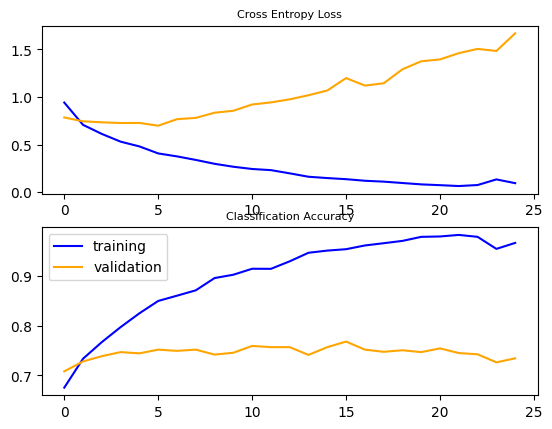

51/51 [==============================] - 3s 16ms/step


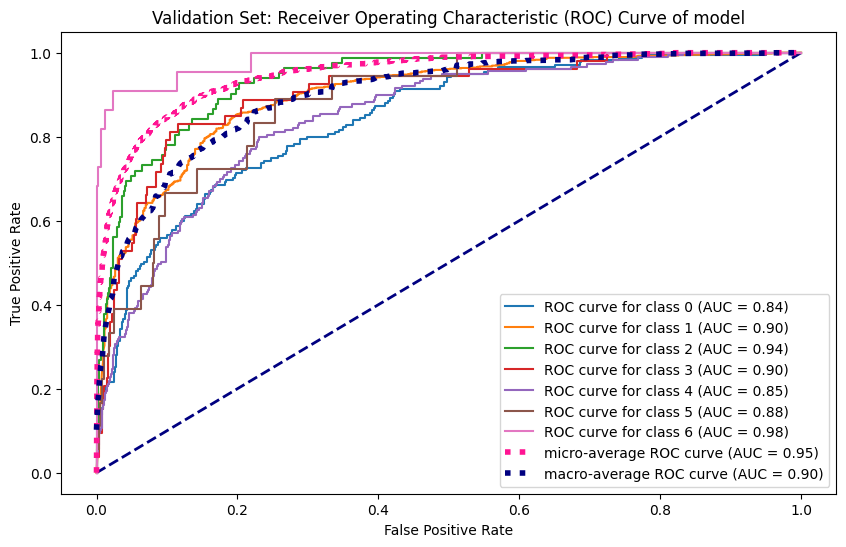

63/63 [==============================] - 2s 26ms/step


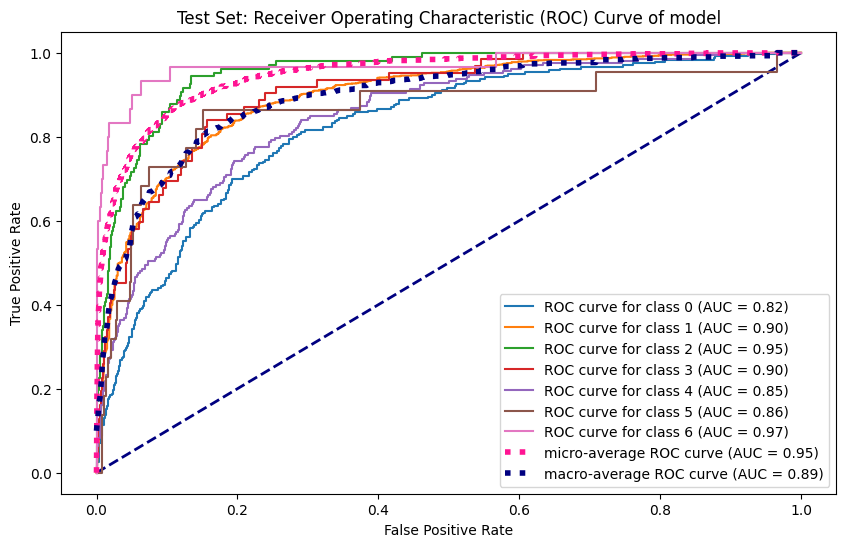

51/51 [==============================] - 1s 16ms/step


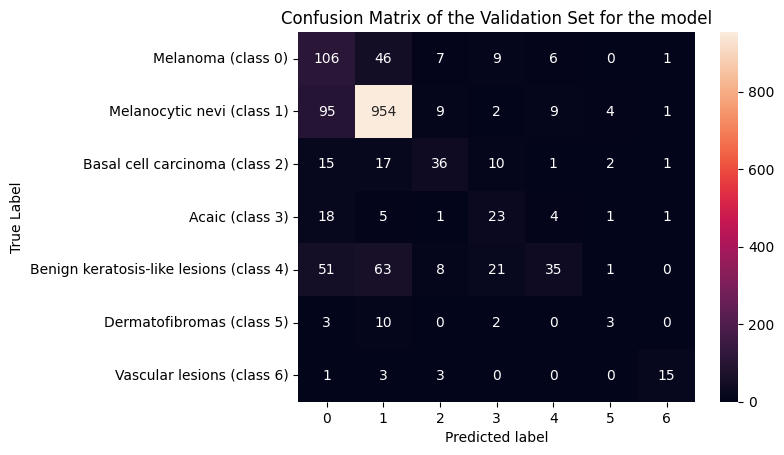

Validation accuracy: 0.731
63/63 [==============================] - 1s 16ms/step


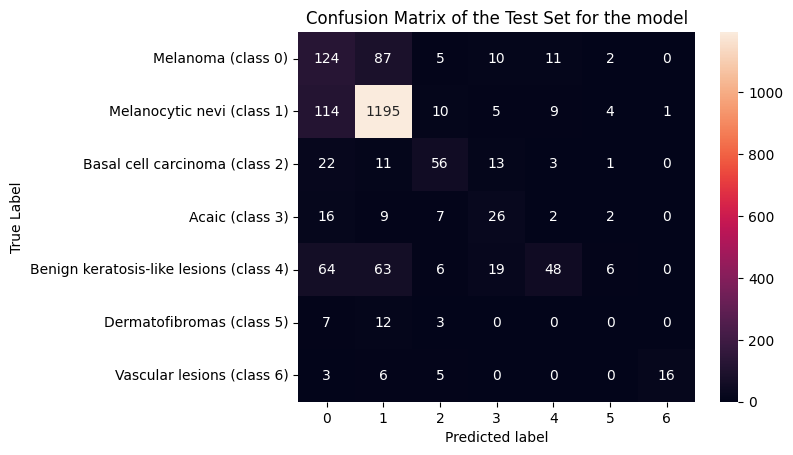

Test accuracy: 0.731
51/51 [==============================] - 1s 16ms/step
Validation Accuracy: 0.731
Validation F1 Score (unweighted mean): 0.493
Validation F1 Score (weighted mean): 0.722

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.457 |         0.872 |         0.606 |
|       1 |      0.878 |         0.728 |         0.888 |
|       2 |      0.493 |         0.982 |         0.439 |
|       3 |      0.383 |         0.972 |         0.434 |
|       4 |      0.299 |         0.986 |         0.196 |
|       5 |      0.207 |         0.995 |         0.167 |
|       6 |      0.732 |         0.997 |         0.682 |
63/63 [==============================] - 1s 16ms/step
Test Accuracy: 0.731
Test F1 Score (unweighted mean): 0.468
Test F1 Score (weighted mean): 0.724

|   Class |   F1 Score |   Specificity |   Sensitivity |
|--------:|-----------:|--------------:|--------------:|
|       0 |      0.421 |      

In [ ]:
# fit & summarize & display metrics
fit_plot(densenet_model, X_train= X_train, y_train= y_train, X_val= X_val, y_val= y_val, X_test= X_test, y_test= y_test, number_of_epochs= 25, batch_size= 32)